# First Year Project - Notebook

## Project 2 - COVID-19 and the Weather

### ITU Copenhagen

**Group 3: Arthur Georges Frederik Kana F de Roey, Gino Franco Fazzi, Jonas Toft-Jensen, Josephine Tia Højer Holst**

Github Repository: joto/fyp2021p02g03

This notebook contains all the code developed for the project.

# Preliminary settings

## Imports

Some of the libraries we will need for our analysis.

In [145]:
import os
import json
import pandas as pd # To create and use DataFrames for all our tables analysis.
import numpy as np
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For plotting
from scipy import stats # For statistical analyis
import textwrap # To prettify our plots' labels
import folium

In [144]:
df = pd.read_json('dk_metadata.json')
df

ValueError: Expected object or value

## Constants

We create our constants, in order to access our data.

In [140]:
PATH = {} # PATH dictionary will contain our main directories for data resources
PATH["data_raw"] = "../data/raw/"
PATH["data_processed"] = "../data/processed/"
PATH["data_external"] = "../data/external/"

FILENAME = {} # FILENAME dictionary will contain our main files and their respectives paths

for path, subdirs, files in os.walk(PATH["data_raw"]):
    for name in files:

        FILENAME[name] = os.path.normpath(os.path.join(path, name))
        



In [141]:
FILENAME

{'dk_corona.csv': '../data/raw/corona/dk_corona.csv',
 'dk.geojson': '../data/raw/shapefiles/dk.geojson',
 'weather2.csv': '../data/raw/weather/weather2.csv',
 'weather.csv': '../data/raw/weather/weather.csv',
 'dk_metadata.json': '../data/raw/metadata/dk_metadata.json'}

## Functions

In [42]:
def numerical_summary(table, variables):
    """A summary and plotting function for numerical values.
    Arguments:
        - table = key of the dataframe selected
        - variables = list with selected columns for summary
    Returns: A table of 5-numbers summary along with a histogram, boxplot and violinplot of the selected columns.
    """
    
    print(f'Table {key} - Summary of numerical variables:') # Header
    display(df[table][variables[table]].describe()) # Call the describe method for Pandas Dataframes to display a 5# summary

    for var in variables[table]: # Iterate through our list of variables to  plot
        if (np.nanmax(df[table][var]) - np.nanmin(df[table][var])) > 20: # If we have a big range, cut off outliers
            Q1 = df[table][var].quantile(0.25) # First Quartile
            Q3 = df[table][var].quantile(0.75) # Third Quartile
            IQR = Q3 - Q1 # Interquartile range
            temp = df[table][var][(df[table][var] > (Q1 - IQR*1.5)) & (df[table][var] < (Q3 + IQR*1.5))] # Consider outliers of
                                                                                                    # 1.5 times the IQR
        else:
            temp = df[table][var] # If there's no big range of numbers, ommit outliers
        fig, ax = plt.subplots(1,3, figsize=(15,5), dpi=350)
        sns.set_theme(style='whitegrid')
        sns.histplot(temp, color='b', alpha=0.75, ax=ax[0]);
        ax[0].set_xlabel("")
        sns.boxplot(y=temp, color='g', boxprops=dict(alpha=.3), orient='v', ax=ax[1]);
        ylim = (0, np.nanmax(temp)+1)
        ax[1].set_ylim(ylim)
        ax[1].set_ylabel("")
        sns.violinplot(y=temp, color='r', boxprops=dict(alpha=.3), inner='point', orient='v', ax=ax[2]);
        ax[2].set_ylabel("")
        ax[2].set_ylim(ylim)
        fig.suptitle(f"{var}")
        #plt.savefig('./plots/numerical-'+table+'-'+var, dpi=350, pad_inches=0.1, metadata=None) # We save the figures for
                                                                                                # final report
        plt.show()
    print('\n')

    """ TO BE MODIFIED """
def create_region_choropleth(country_code, country_region_json, country_metadata_df):
    fig = px.choropleth(title='<b>Country Geospatial Selection & Population: {}</b>'.format(country_code),
                        geojson=country_region_json, featureidkey="properties.iso3166-2_code", 
                        data_frame=country_metadata_df,locations='iso3166-2_code',
                        color='population',
                        color_continuous_scale = 'Blues')
    fig.update_geos(fitbounds="locations", projection={'type':'mercator'}, visible=False)
    fig.update_layout(
        margin={"r":0,"t":40,"l":0,"b":0}, height=400,
        yaxis=dict(position=0),
        font_size=8,title=dict(x=0,font_size=16),
        legend=dict(title_font_size=10, font_size=8),        
        coloraxis_colorbar=dict(title="Population",lenmode="pixels", len=300))
    fig.show()

# Loading the Data and preliminary EDA

In [ ]:
Groupby: hospitalisation    
Groupby: region
Groupby: Weather

## Load raw data

We load the data depending on the file extension.

In [44]:
df = {}
for file, path in FILENAME.items():
    key = file[:file.index(".")]
    if file[file.index("."):] == ".csv":
        df[key] = pd.read_csv(path, sep='\t')
    elif file[file.index("."):] == ".json":
        df[key] = json.load(open(path))
    else:
        df[key] = json.load(open(path))

In [146]:
df

{'dk_corona':             date                region_code  hospitalized_addition
 0     2020-03-01  Capital Region of Denmark                      1
 1     2020-03-02  Capital Region of Denmark                      0
 2     2020-03-03  Capital Region of Denmark                      1
 3     2020-03-04  Capital Region of Denmark                      0
 4     2020-03-05  Capital Region of Denmark                      1
 ...          ...                        ...                    ...
 1755  2021-02-11       North Denmark Region                      1
 1756  2021-02-12       North Denmark Region                      1
 1757  2021-02-13       North Denmark Region                      1
 1758  2021-02-14       North Denmark Region                      1
 1759  2021-02-15       North Denmark Region                      2
 
 [1760 rows x 3 columns],
 'dk': {'type': 'FeatureCollection',
  'crs': {'type': 'name',
   'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
  'features': [{'ty

# Load json into df 

### We inspect the metadata for insights on how the data is structured.

In [45]:
df['dk_metadata'].keys()

dict_keys(['country_data_sources', 'country_metadata'])

We see the metadata on Denmark has two main headers. We will inspect the country metada.

In [46]:
df['dk_metadata']['country_metadata']

[{'iso3166-1_code': 'DK',
  'iso3166-1_name': 'Denmark',
  'iso3166-2_code': 'DK-81',
  'iso3166-2_name_en': 'North Denmark Region',
  'population': 589936,
  'covid_region_code': 'North Denmark Region'},
 {'iso3166-1_code': 'DK',
  'iso3166-1_name': 'Denmark',
  'iso3166-2_code': 'DK-82',
  'iso3166-2_name_en': 'Central Denmark Region',
  'population': 1326340,
  'covid_region_code': 'Central Denmark Region'},
 {'iso3166-1_code': 'DK',
  'iso3166-1_name': 'Denmark',
  'iso3166-2_code': 'DK-83',
  'iso3166-2_name_en': 'Region of Southern Denmark',
  'population': 1223105,
  'covid_region_code': 'Region of Southern Denmark'},
 {'iso3166-1_code': 'DK',
  'iso3166-1_name': 'Denmark',
  'iso3166-2_code': 'DK-84',
  'iso3166-2_name_en': 'Capital Region of Denmark',
  'population': 1846023,
  'covid_region_code': 'Capital Region of Denmark'},
 {'iso3166-1_code': 'DK',
  'iso3166-1_name': 'Denmark',
  'iso3166-2_code': 'DK-85',
  'iso3166-2_name_en': 'Region Zealand',
  'population': 837359,


We find here the different ISO codes for the danish regions. We will use those to subset our weather data.

## Subset the data

We subset the data and inmediately save it to a new file. But first, we need to merge the 2 different weather datasets.

In [47]:
df['weather'] = df['weather'].merge(df['weather2'], how='outer') # Merge second dataset into the first

In [48]:
# Subset the Danish data
df['weather'][df['weather']['iso3166-2'].str.contains('DK-')].to_csv(PATH["data_processed"] + 'dk_weather.csv', index=False)

In [49]:
# Delete the superfluous second weather dataset
del df['weather2']

We reconfigure our path to use our filtered file.

In [50]:
df['weather'] = pd.read_csv(PATH["data_processed"] + 'dk_weather.csv')

### We create a simpler dictionary to hold our regions' codes and their respective names.

In [51]:
regions_by_code = {}

for code in df['dk_metadata']['country_metadata']:
    code_nr = code['iso3166-2_code']
    regions_by_code[code_nr] = code['covid_region_code']

## First Exploratory Data Analysis

### Is there any missing values?

In [52]:
df['dk_corona'].isna().any().any()

False

In [147]:
df['dk_corona']

,date,region_code,hospitalized_addition
0,2020-03-01,Capital Region of Denmark,1
1,2020-03-02,Capital Region of Denmark,0
2,2020-03-03,Capital Region of Denmark,1
3,2020-03-04,Capital Region of Denmark,0
4,2020-03-05,Capital Region of Denmark,1
...,...,...,...
1755,2021-02-11,North Denmark Region,1
1756,2021-02-12,North Denmark Region,1
1757,2021-02-13,North Denmark Region,1
1758,2021-02-14,North Denmark Region,1


In [53]:
df['weather'].isna().any().any()

False

Our first shallow inspection throws no missing values in our 2 main datasets.

### Shape, number and meaning of fields and records

In [54]:
print(f'Dataset Corona contains {df["dk_corona"].shape[1]} fields and {df["dk_corona"].shape[0]} records.')
print(f'Dataset Weather contains {df["weather"].shape[1]} fields and {df["weather"].shape[0]} records.')   

Dataset Corona contains 3 fields and 1760 records.
Dataset Weather contains 9 fields and 1845 records.


In [55]:
df['dk_corona'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1760 entries, 0 to 1759
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   date                   1760 non-null   object
 1   region_code            1760 non-null   object
 2   hospitalized_addition  1760 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 41.4+ KB


In [56]:
df['weather'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1845 entries, 0 to 1844
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     1845 non-null   object 
 1   iso3166-2                1845 non-null   object 
 2   RelativeHumiditySurface  1845 non-null   float64
 3   SolarRadiation           1845 non-null   float64
 4   Surfacepressure          1845 non-null   float64
 5   TemperatureAboveGround   1845 non-null   float64
 6   Totalprecipitation       1845 non-null   float64
 7   UVIndex                  1845 non-null   float64
 8   WindSpeed                1845 non-null   float64
dtypes: float64(7), object(2)
memory usage: 129.9+ KB


Our first dataset is quite simple: contains only date, region and number of hospitalized patients. 
Our second dataset contains as well date, ISO code for the region and then numeric variables: humidity, radiation, pressure, temperature, precipitation, UV index and windspeed.

### Do the 2 main datasets contain records for the same date range?

In [57]:
print('Corona dataset: Start: {} - End: {}'.format(df['dk_corona']['date'].iloc[0], df['dk_corona']['date'].iloc[-1]))
print('Weather dataset: Start: {} - End: {}'.format(df['weather']['date'].iloc[0], df['weather']['date'].iloc[-1]))

Corona dataset: Start: 2020-03-01 - End: 2021-02-15
Weather dataset: Start: 2020-02-13 - End: 2021-02-15


There seems to be a small mismatch in the dates. Our weather dataset starts 15 days before our Corona dataset. This becomes useful if we assume that covid has a max incubation period of 14 days.
With the new merged data we now have weather data until the final period of mid February.

In [107]:
df['dk_corona']

,date,region_code,hospitalized_addition
0,2020-03-01,Capital Region of Denmark,1
1,2020-03-02,Capital Region of Denmark,0
2,2020-03-03,Capital Region of Denmark,1
3,2020-03-04,Capital Region of Denmark,0
4,2020-03-05,Capital Region of Denmark,1
...,...,...,...
1755,2021-02-11,North Denmark Region,1
1756,2021-02-12,North Denmark Region,1
1757,2021-02-13,North Denmark Region,1
1758,2021-02-14,North Denmark Region,1


In [19]:
display(df['dk_corona'].describe())
display(df['weather'].describe())

,hospitalized_addition
count,1760.000000
mean,6.825000
std,11.904063
min,0.000000
25%,0.000000
50%,3.000000
75%,8.000000
max,101.000000


,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
count,1845.000000,1.845000e+03,1.845000e+03,1845.000000,1845.000000,1845.000000,1845.000000
mean,80.298806,6.900569e+06,2.425409e+06,282.535129,0.002127,14.701756,4.452396
std,10.456537,6.616148e+06,2.584014e+04,6.306567,0.003332,14.080710,1.973627
min,46.166826,0.000000e+00,2.342463e+06,265.409594,0.000000,0.000000,0.804547
25%,72.926710,8.041646e+05,2.408483e+06,277.807418,0.000091,0.105712,2.984007
50%,81.533717,4.519063e+06,2.426780e+06,282.187354,0.000773,10.603854,4.165541
75%,88.968224,1.239336e+07,2.442136e+06,287.511456,0.002849,26.872979,5.627276
max,98.192610,2.407046e+07,2.494230e+06,296.353250,0.041373,44.536232,12.495682


For the Corona table we check there are 1760 records (as mentioned before), with a mean of 6.825 patients hospitalized and a median of 3. We can see that the 75 percentile is 8 and the max is 101, which indicates an uneven distribution. 
For the Weather table we visualize very different scales for some of the variables. We will need further research to be able to interpret those values.

## Visual Exploration

We check the distribution of the records with a boxplot.

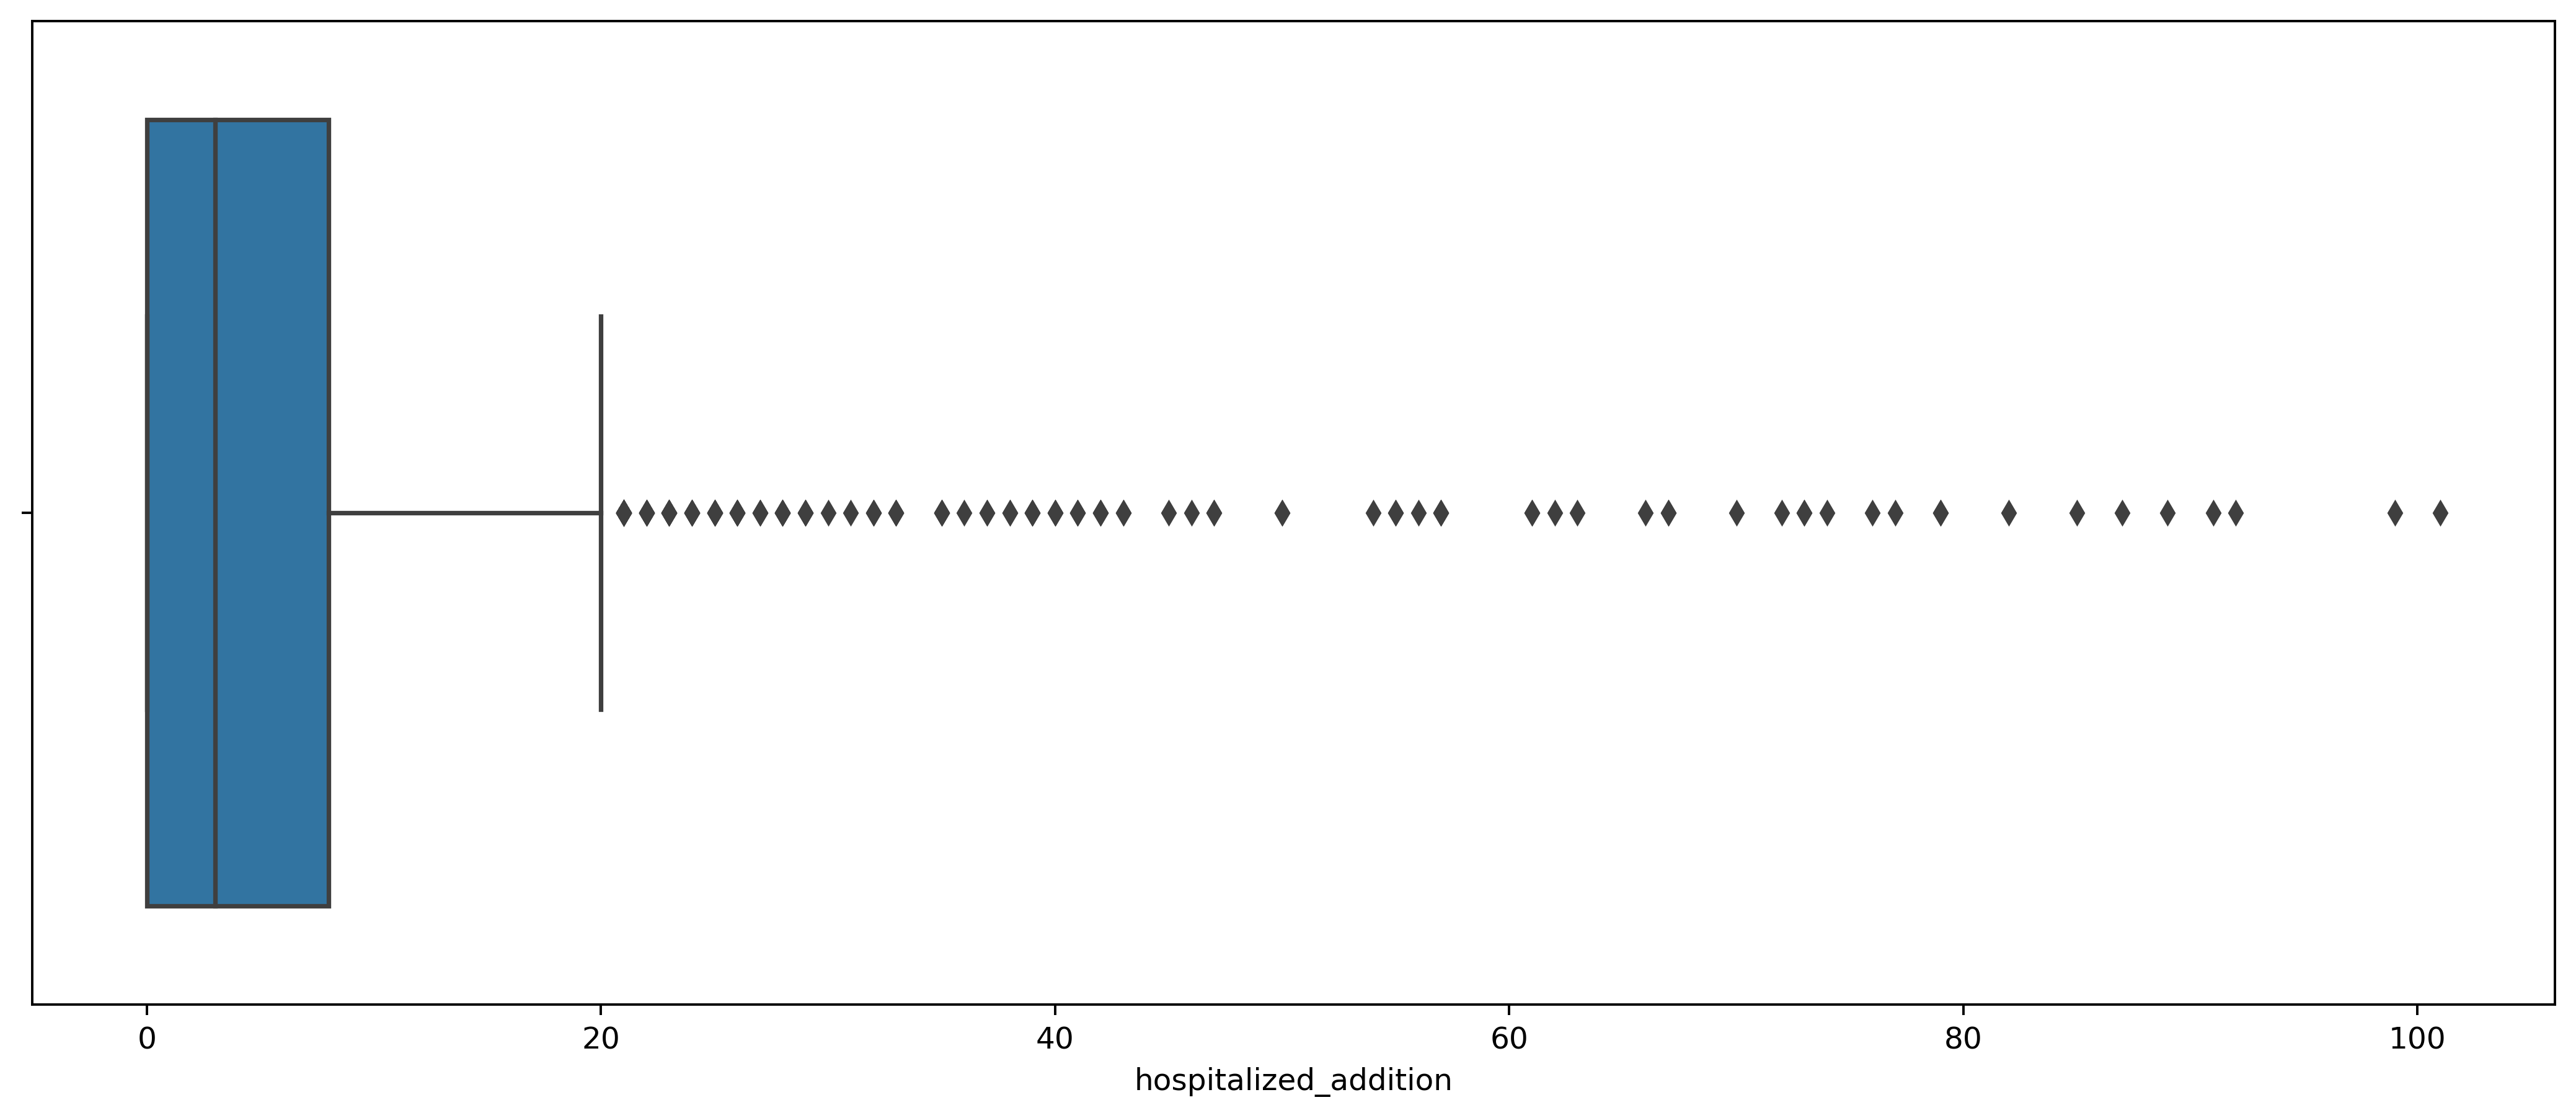

In [20]:
fig, ax = plt.subplots(figsize=(15,6), dpi=350)
ax = sns.boxplot(x='hospitalized_addition', data=df['dk_corona'])

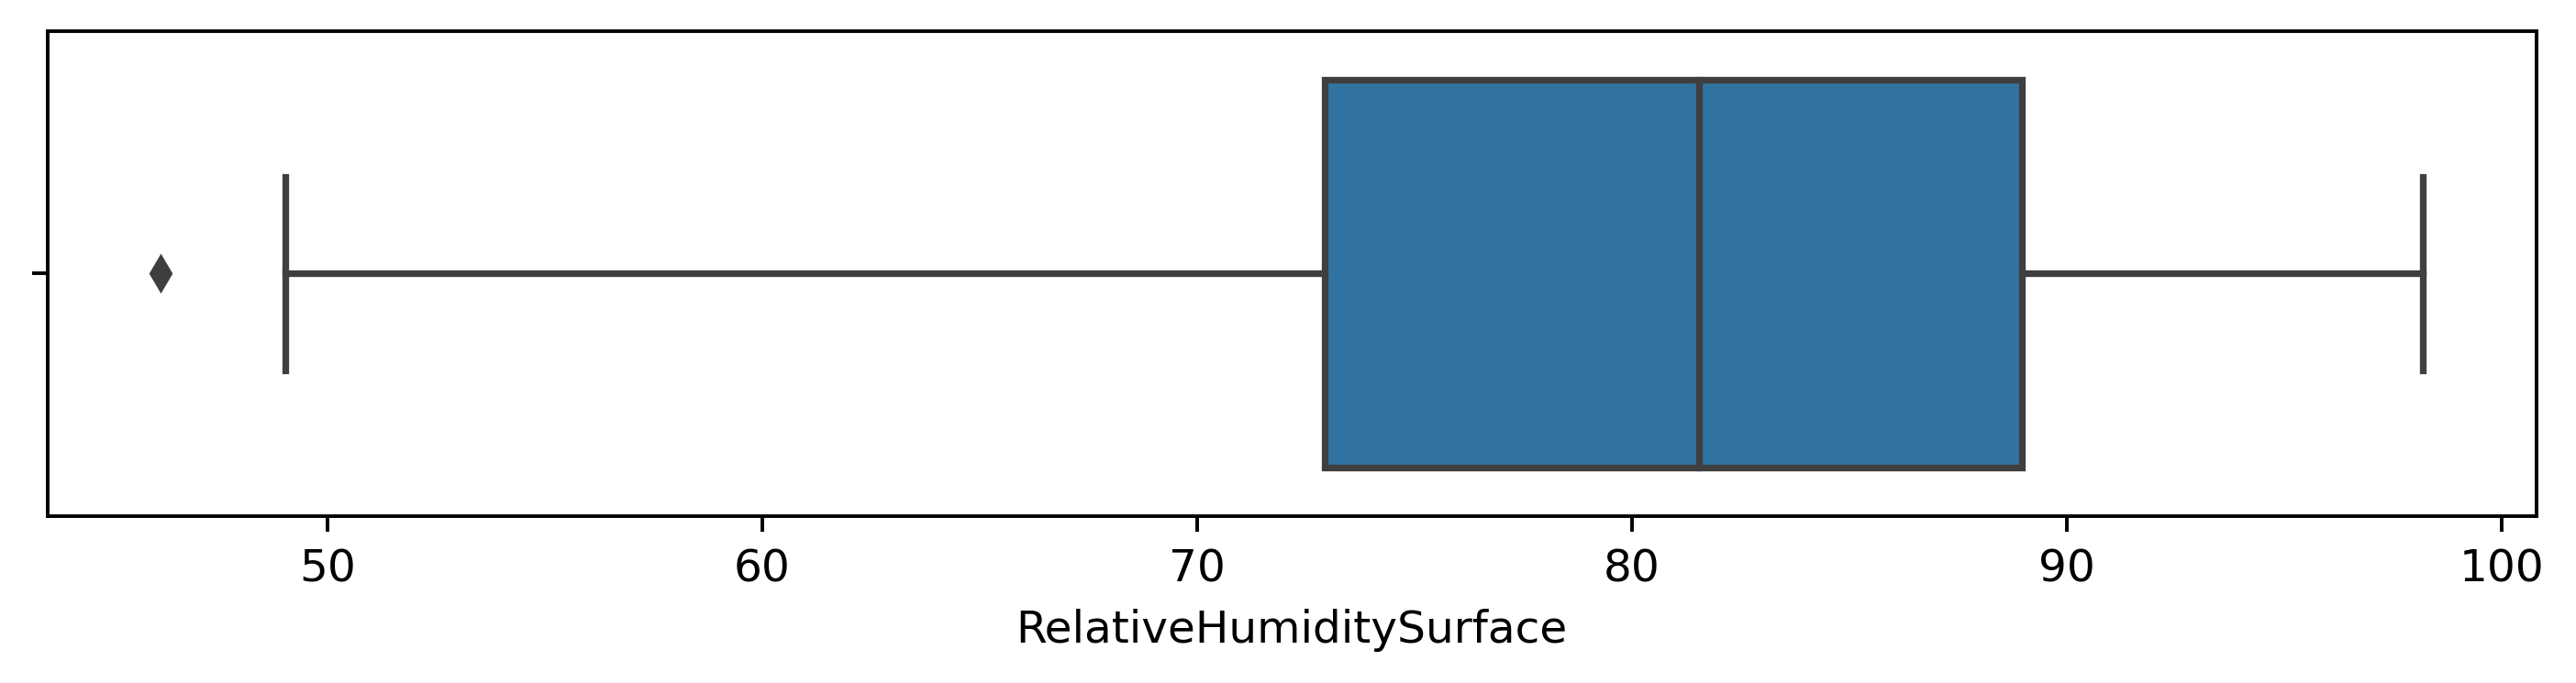

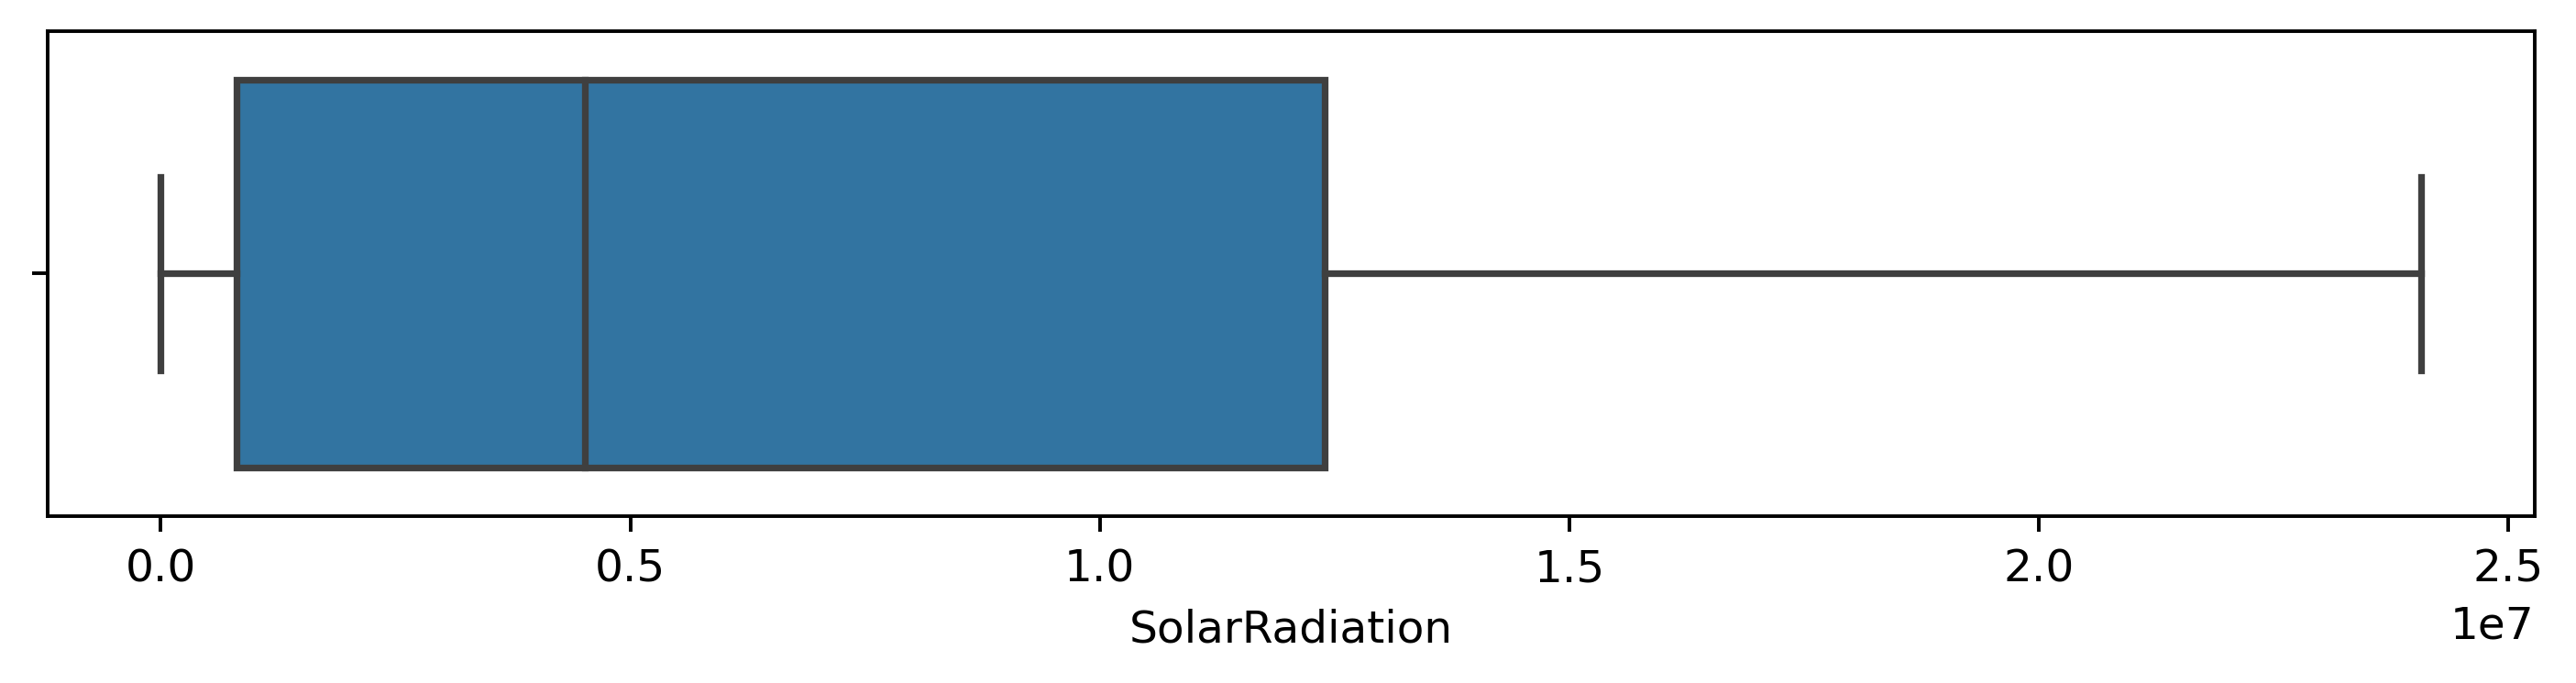

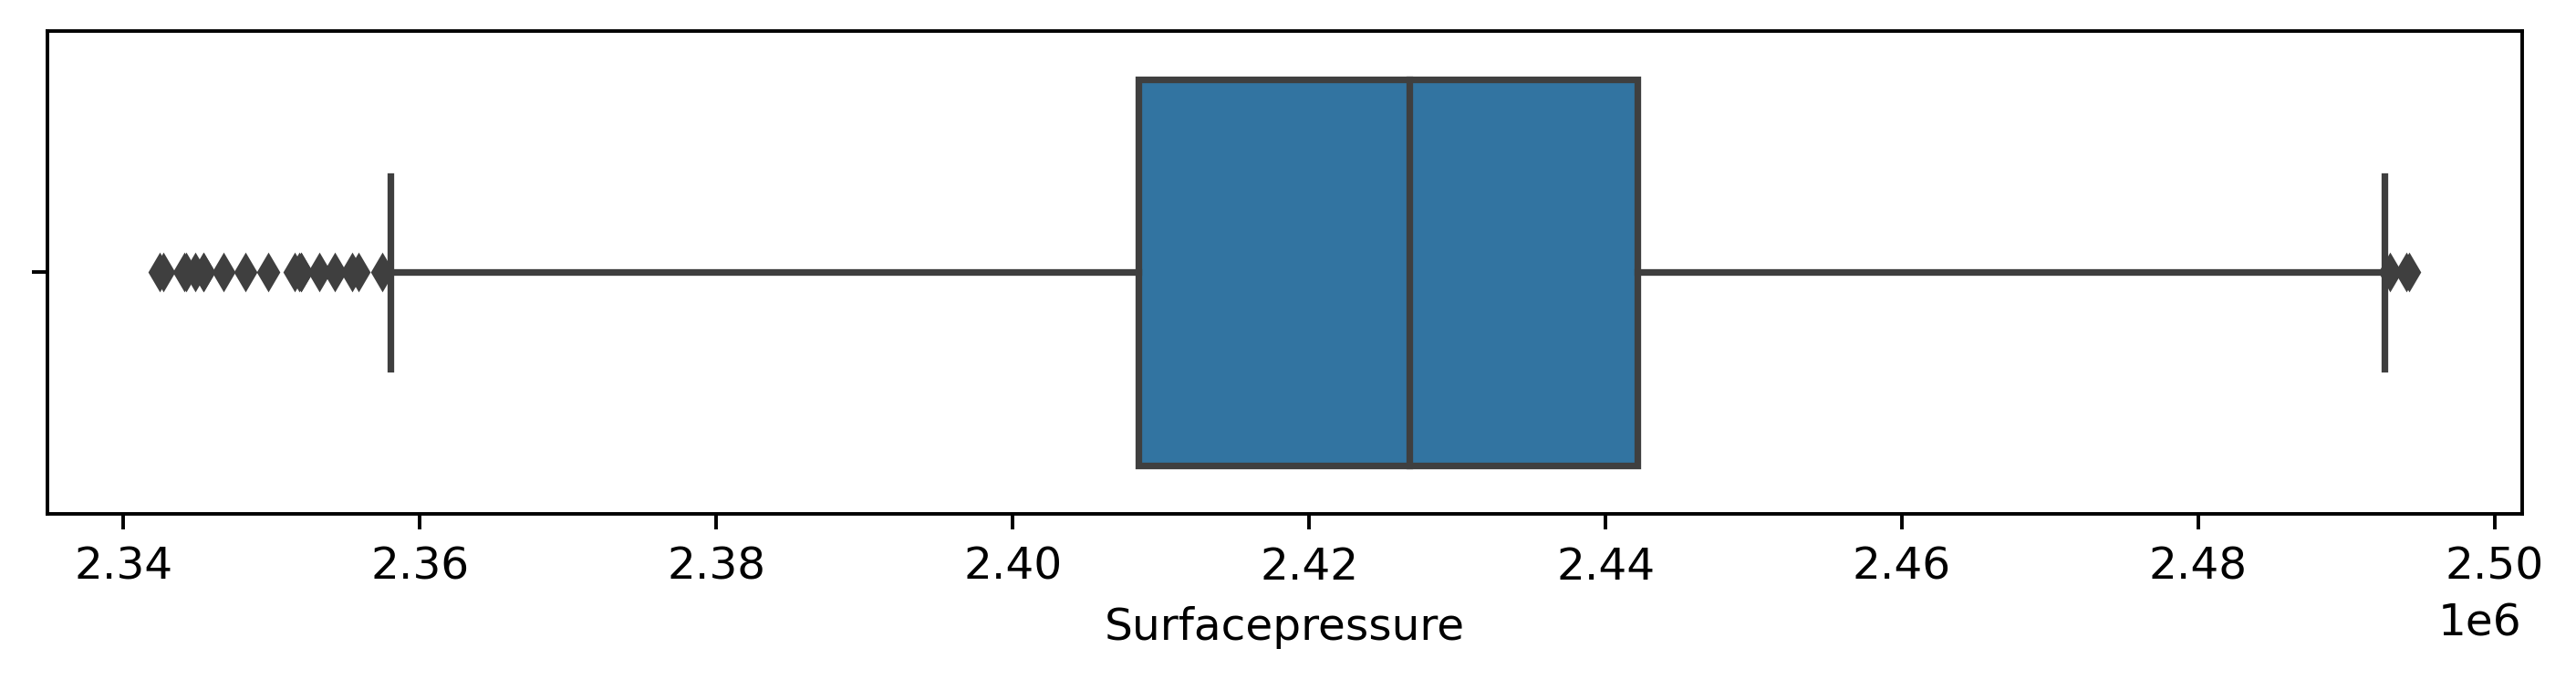

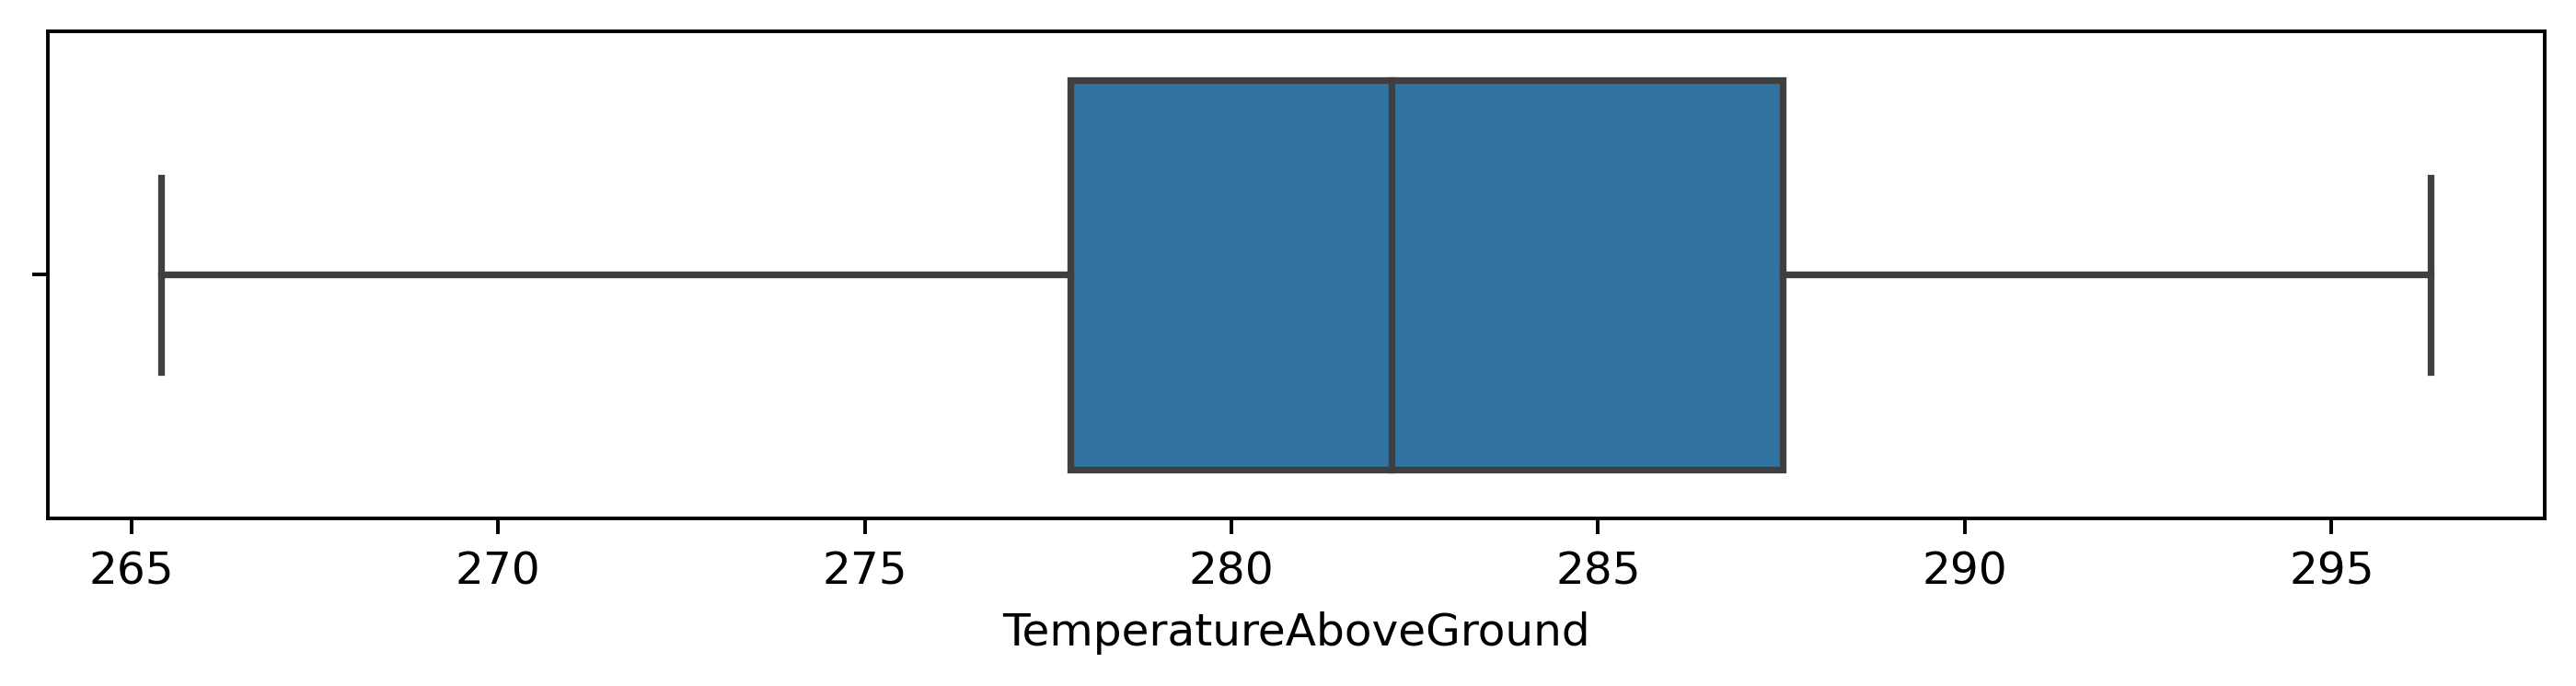

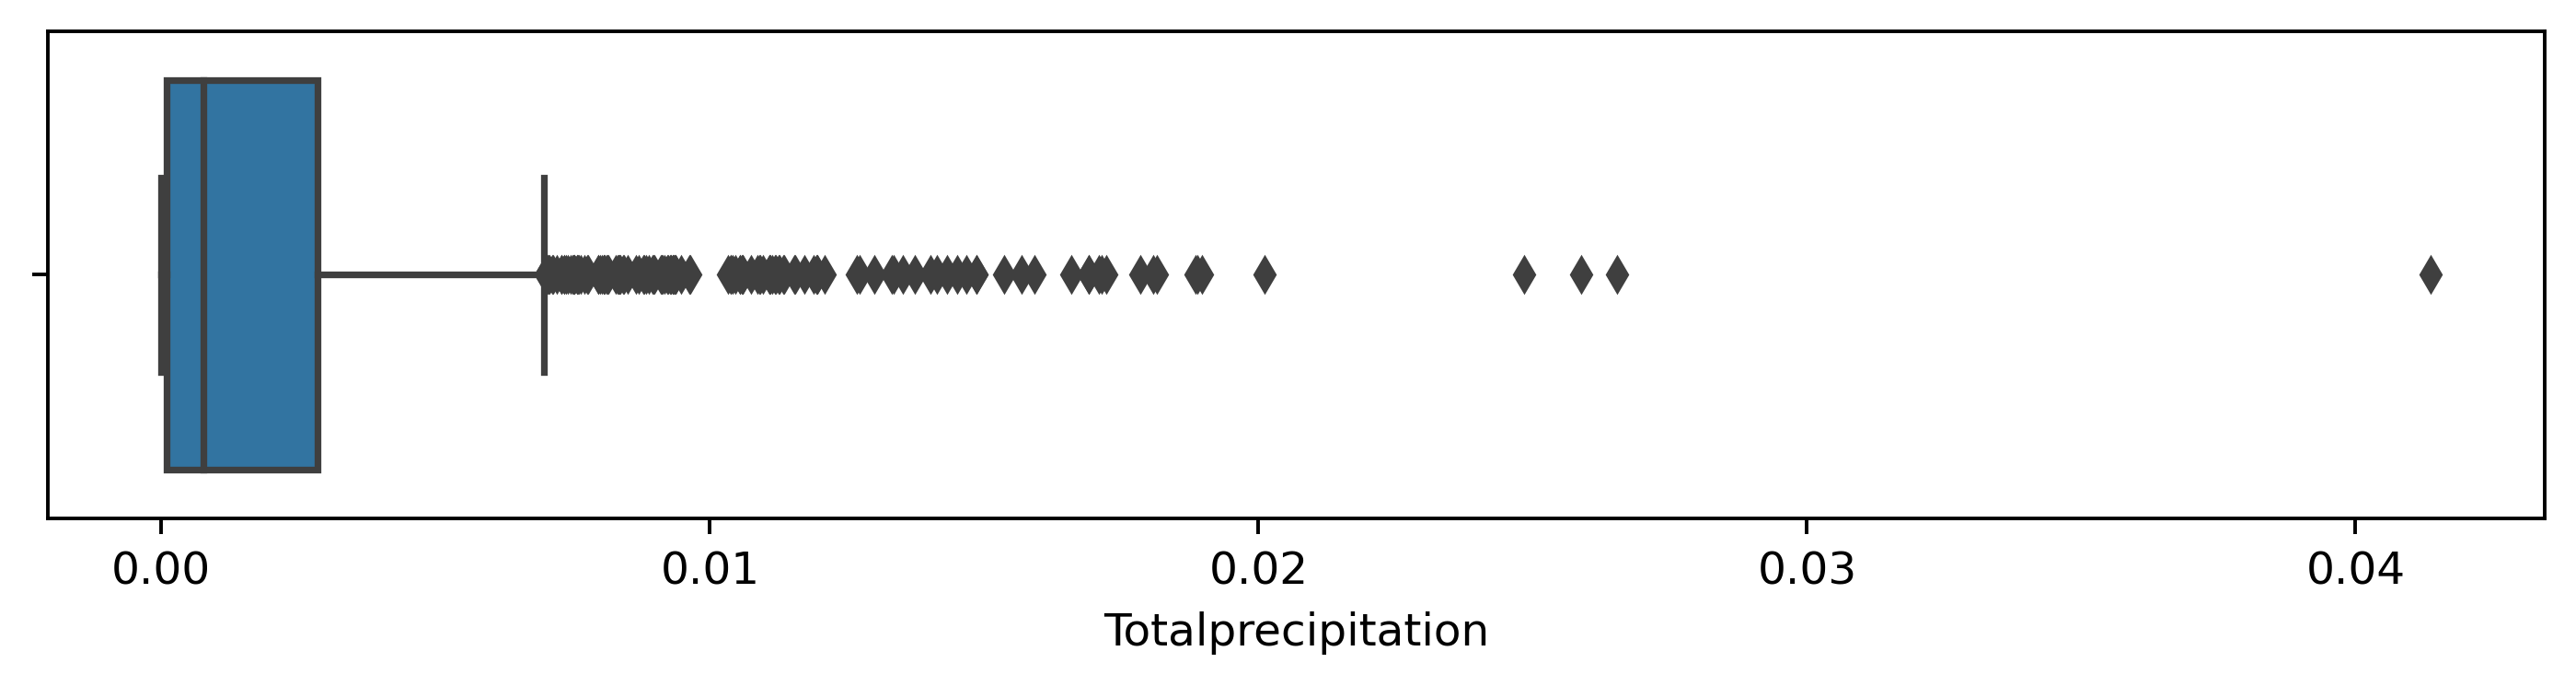

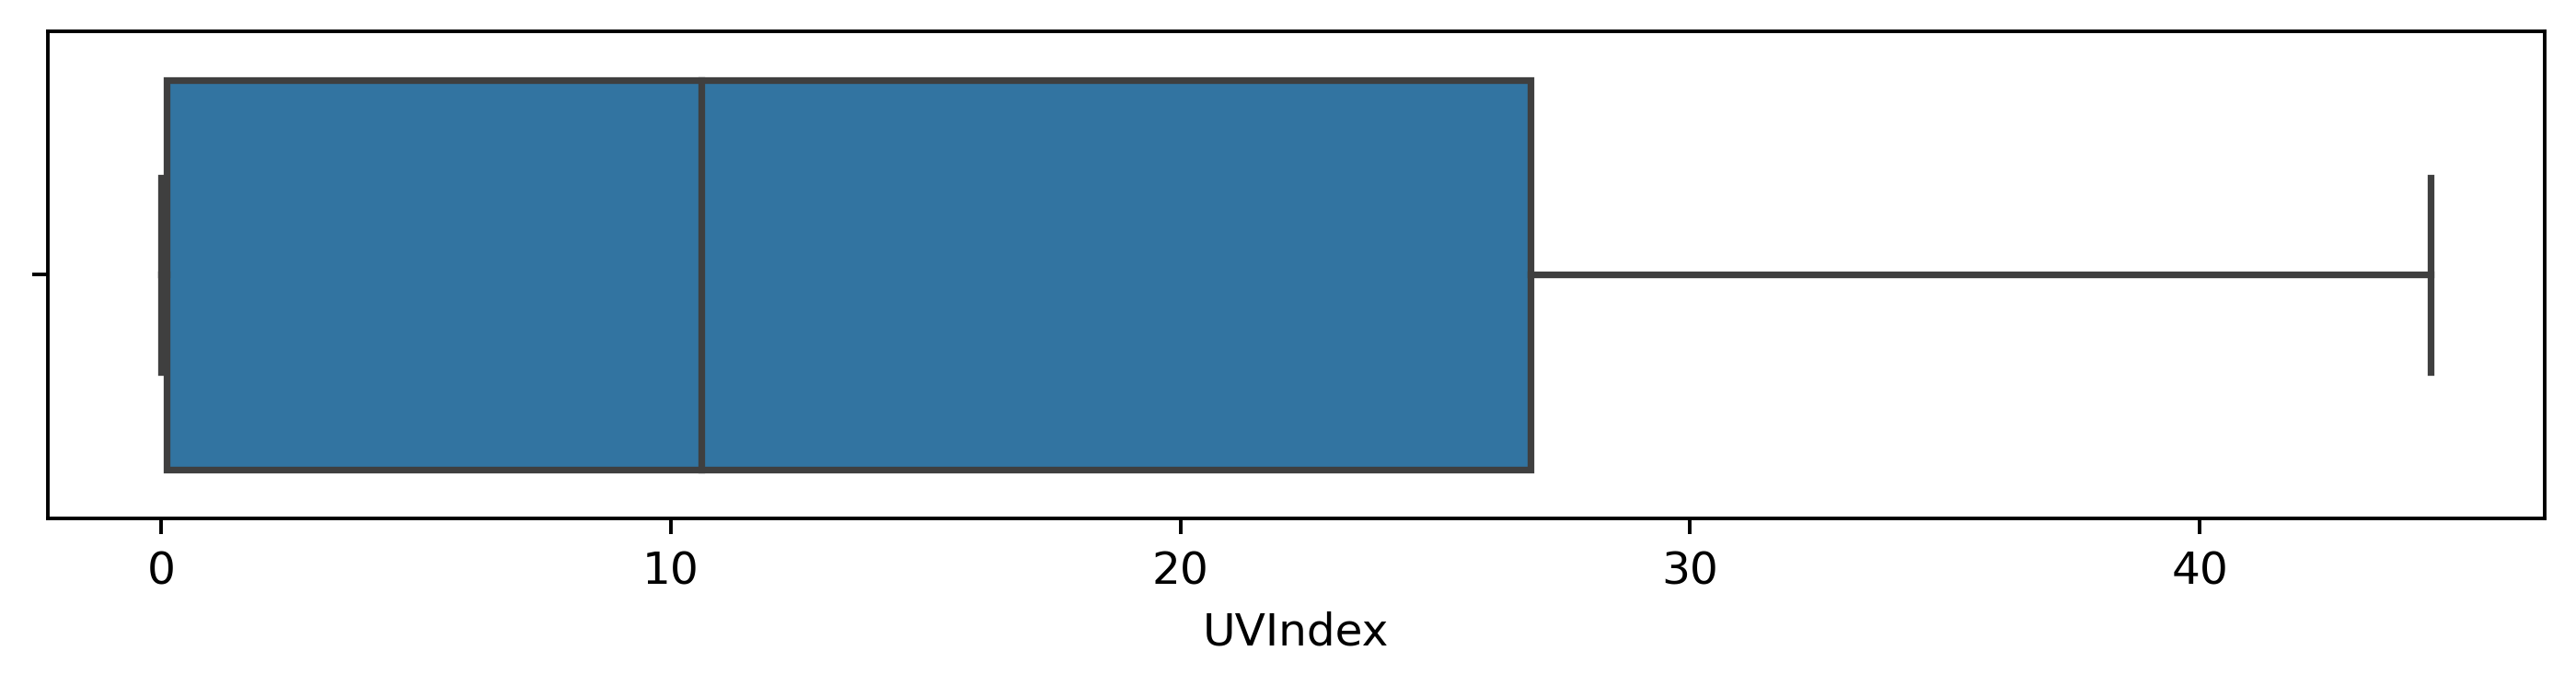

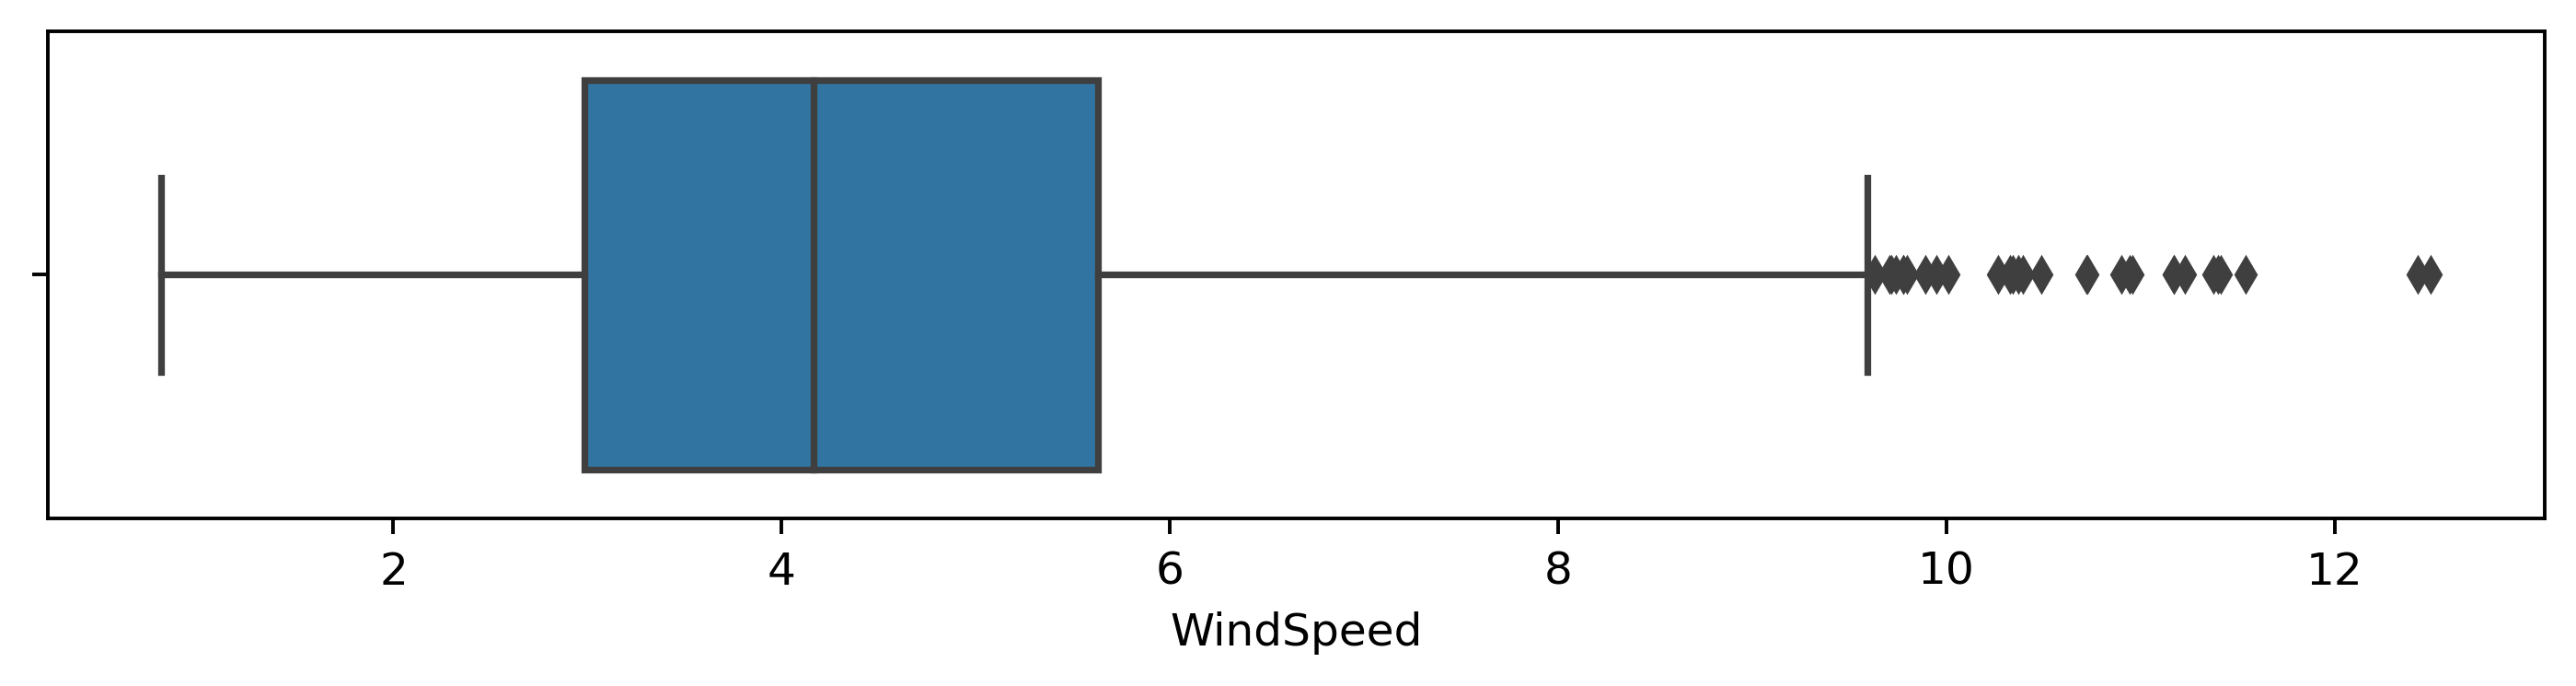

In [21]:
vars = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround', 'Totalprecipitation',
       'UVIndex', 'WindSpeed']

for v in vars:
    try:
        fig, ax = plt.subplots(figsize=(10,2),dpi=350)
        sns.boxplot(x= v, data= df['weather'])
    except: pass

# First spatial inspection of territory

In [22]:
m = folium.Map(location = [56, 10.3], zoom_start = 7)

m

In [23]:
# We now load the geoJSON which contains the bonduaries for the country's regions
folium.GeoJson(df['dk'], name = "geojson").add_to(m)

folium.LayerControl().add_to(m)

m

In [24]:
weather_by_region = df['weather'].groupby('iso3166-2').mean()

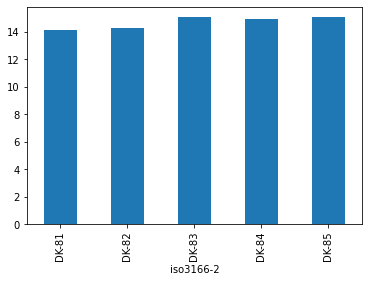

In [25]:
weather_by_region['UVIndex'].plot(kind='bar');

After careful inspection we notice very strange values for the UV Index in the different regions of Denmark. We consult the UV Index values of reference (https://en.wikipedia.org/wiki/Ultraviolet_index) and we confirm these values are extremely unlikely for Denmark.
After consulting with the data source, we now know the data has been aggregated as the daily sum of the hourly records. Therefor, the plot is showing the average of daily accumulated UV Index per region.
As expected, in a small country as Denmark the UV Index difference among regions is minimal.

## Let's have a quick overview of the weather data for the whole period.

In [26]:
weather_by_date = df['weather'].groupby('date').mean()

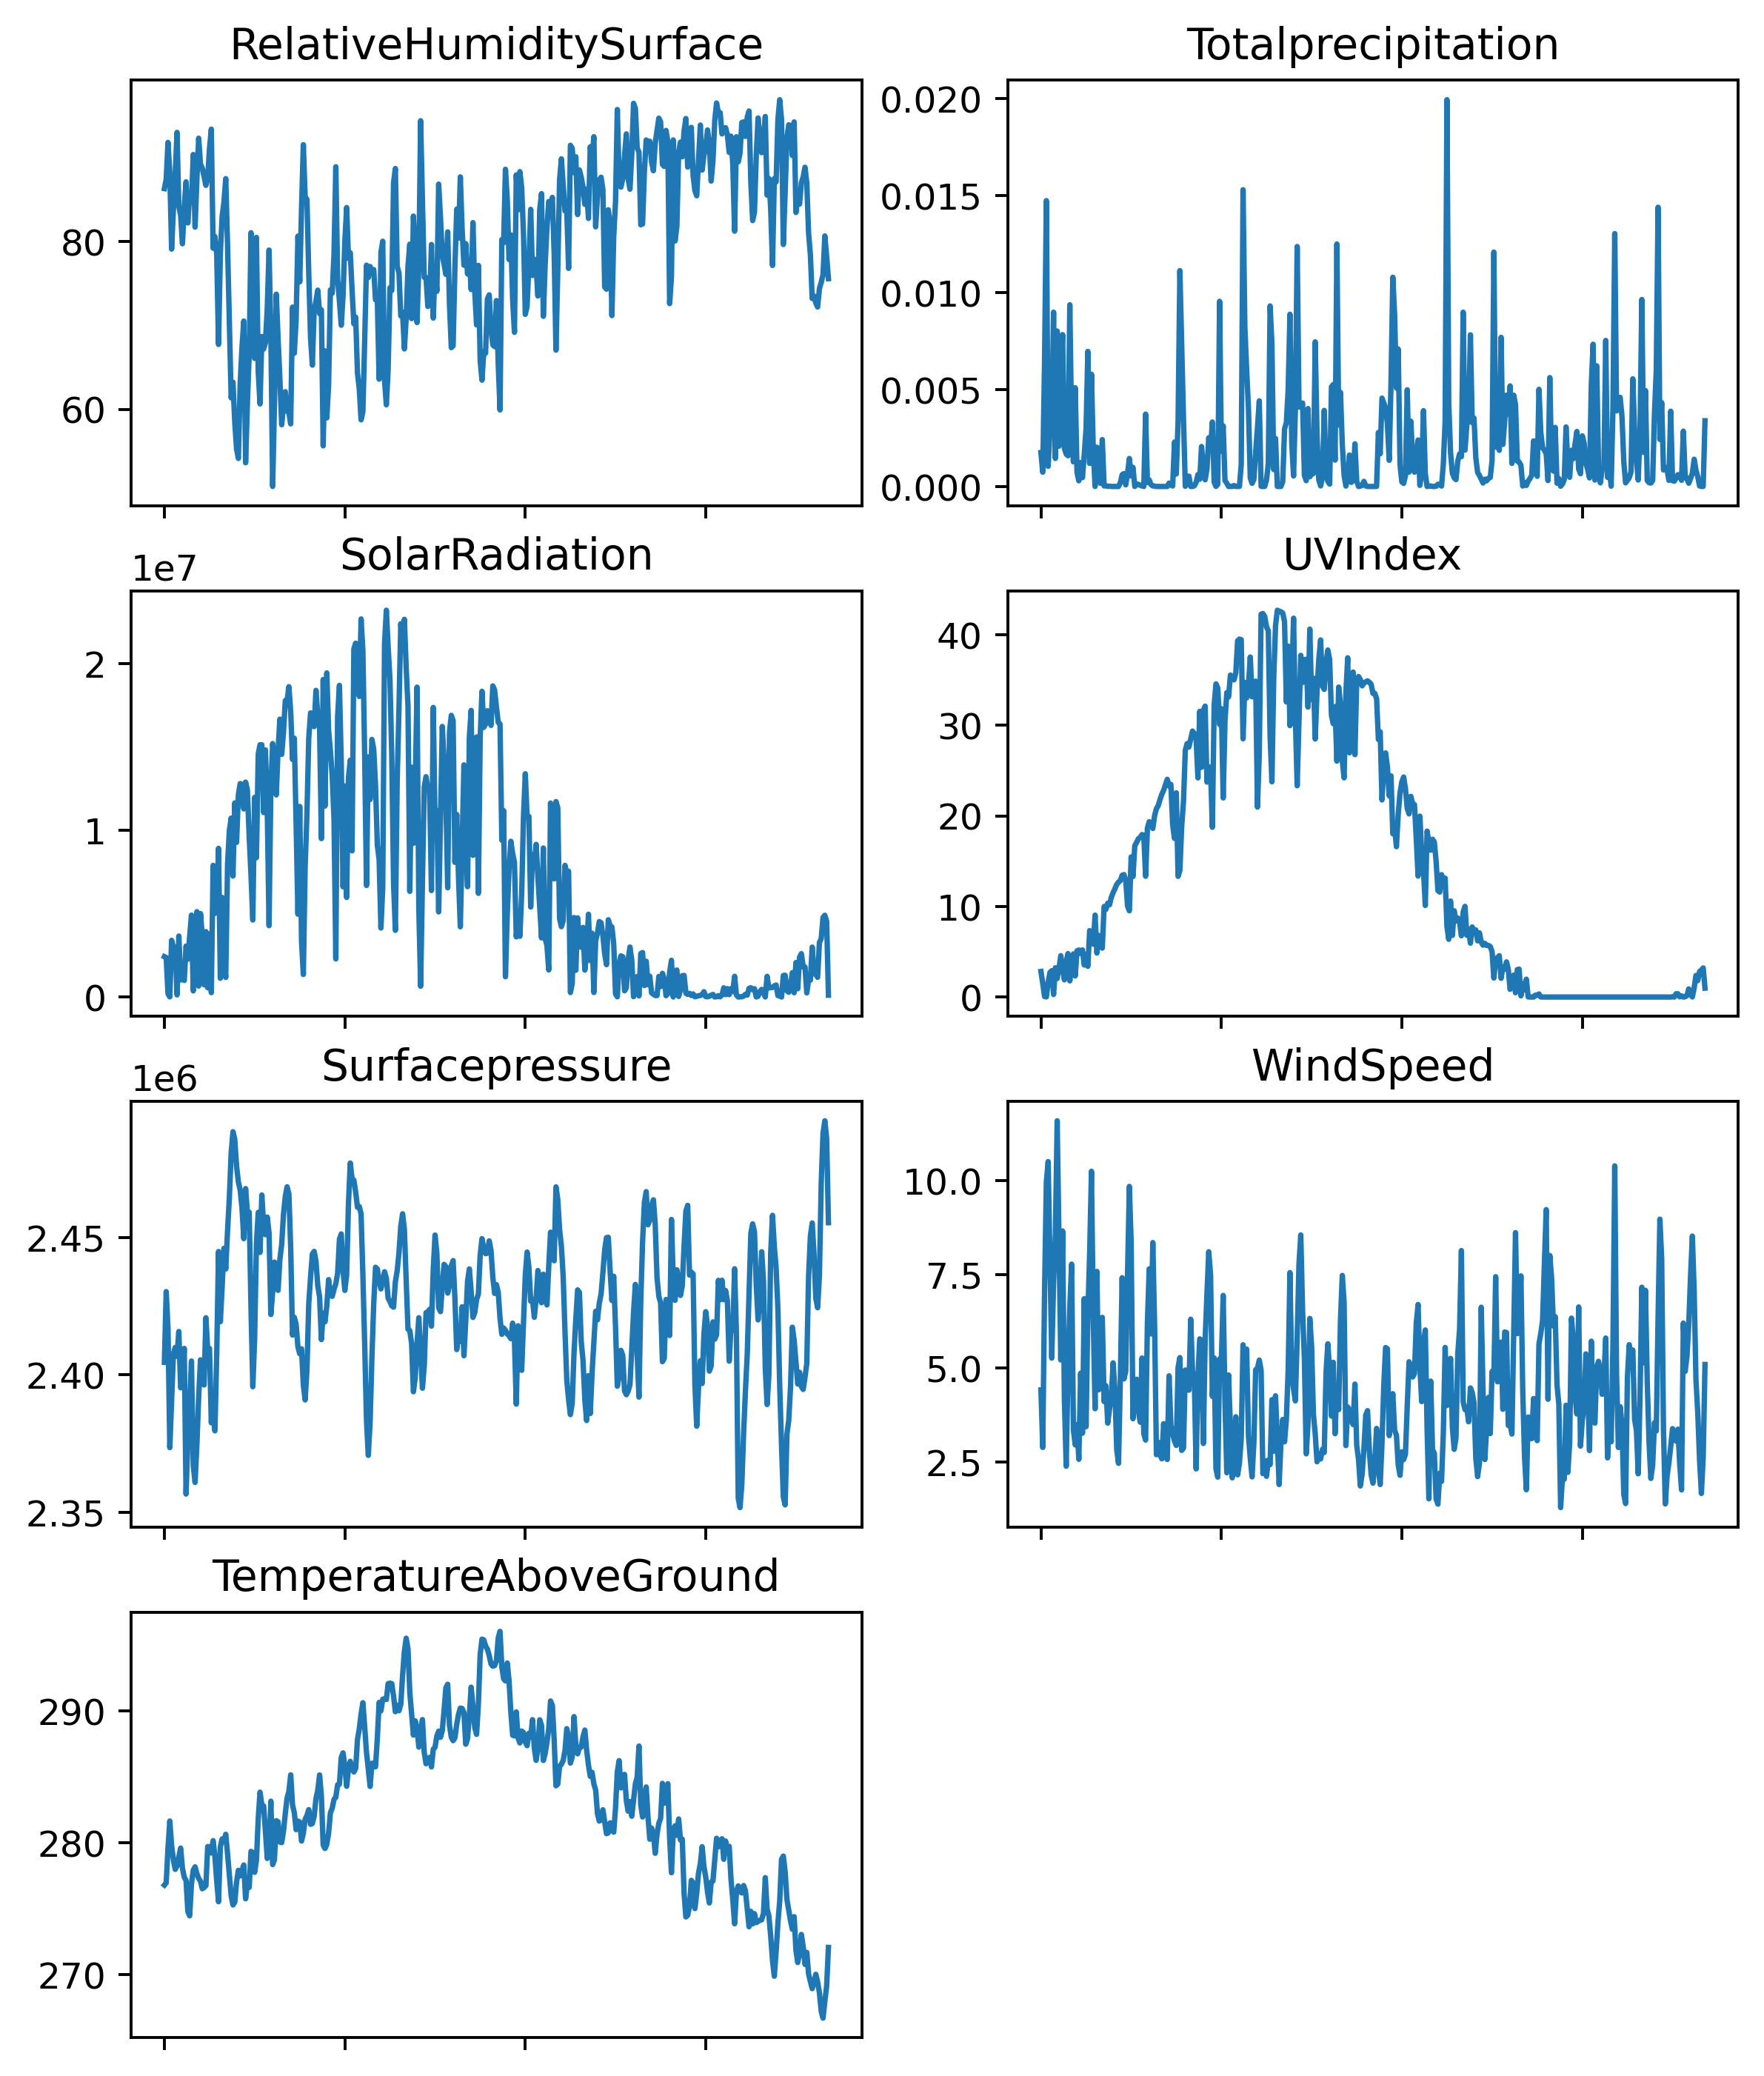

In [27]:
fig, ax = plt.subplots(4,2, figsize=(8,10), dpi=350)

for col_nr in range(len(weather_by_date.columns)):
    if col_nr < 4: axi,axj = col_nr, 0
    else: axi, axj = col_nr-4, 1
    weather_by_date[list(weather_by_date.columns)[col_nr]].plot(ax=ax[axi, axj])
    ax[axi, axj].set_xticklabels("")
    ax[axi, axj].set_xlabel("")
    ax[axi, axj].set_title(list(weather_by_date.columns)[col_nr])

fig.delaxes(ax[3,1])

### Applying consistency

Since our 'weather' dataset has only the 'iso3166-2' code for region, and our corona datasets has the region name, we decide to append the region name to our 'weather' table.

In [28]:
regions = []

for ix, row in df['weather'].iterrows():
    regions.append(regions_by_code[row['iso3166-2']])

In [29]:
df['weather']['region_code'] = regions

## Putting it all together

We merge our corona table with the weather table, and subset our variables of interest.

In [122]:
df

{'dk_corona':             date                region_code  hospitalized_addition
 0     2020-03-01  Capital Region of Denmark                      1
 1     2020-03-02  Capital Region of Denmark                      0
 2     2020-03-03  Capital Region of Denmark                      1
 3     2020-03-04  Capital Region of Denmark                      0
 4     2020-03-05  Capital Region of Denmark                      1
 ...          ...                        ...                    ...
 1755  2021-02-11       North Denmark Region                      1
 1756  2021-02-12       North Denmark Region                      1
 1757  2021-02-13       North Denmark Region                      1
 1758  2021-02-14       North Denmark Region                      1
 1759  2021-02-15       North Denmark Region                      2
 
 [1760 rows x 3 columns],
 'dk': {'type': 'FeatureCollection',
  'crs': {'type': 'name',
   'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
  'features': [{'ty

In [30]:
covid_uv = df['dk_corona'].merge(df['weather'], on=['date', 'region_code'], how='right')\
[['date', 'region_code','hospitalized_addition','UVIndex']]

In [64]:
covid_uv

,date,region_code,hospitalized_addition,UVIndex,UV_15d
0,2020-03-01,Capital Region of Denmark,1.0,2.595843,NaN
1,2020-03-02,Capital Region of Denmark,0.0,4.286374,NaN
2,2020-03-03,Capital Region of Denmark,1.0,1.676674,NaN
3,2020-03-04,Capital Region of Denmark,0.0,4.771363,NaN
4,2020-03-05,Capital Region of Denmark,1.0,4.919169,NaN
...,...,...,...,...,...
1840,2020-02-29,North Denmark Region,NaN,0.479024,50.511510
1841,2020-02-29,Central Denmark Region,NaN,1.221945,49.712507
1842,2020-02-29,Region of Southern Denmark,NaN,3.439507,51.163791
1843,2020-02-29,Capital Region of Denmark,NaN,1.478060,51.517140


In [63]:
print(covid_uv.corr(method="spearman"))


                       hospitalized_addition   UVIndex    UV_15d
hospitalized_addition               1.000000 -0.665670 -0.700193
UVIndex                            -0.665670  1.000000  0.964185
UV_15d                             -0.700193  0.964185  1.000000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Pearson fit (default method)
fit = np.polyfit(x=data['US GDP'], y=data['S&amp;P 500'], deg=1)
line_fit = np.poly1d(fit)
plt.plot(data['US GDP'], line_fit(data['US GDP']))
plt.scatter(x=data['US GDP'], y=data['S&amp;P 500'], color='red', alpha=0.1)
plt.title("Pearson correlation")
plt.show()


We will calculate a 15 day acumulation of UV Index.

In [31]:
covid_uv['UV_15d'] = covid_uv['UVIndex'].rolling(15).sum()

In [72]:
covid_uv['UV_15d'].keys()

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844],
           dtype='int64', length=1845)

In [76]:
covid_uv['UV_15d'].shape

(1845,)

We make a first scatterplot for visual inspection.

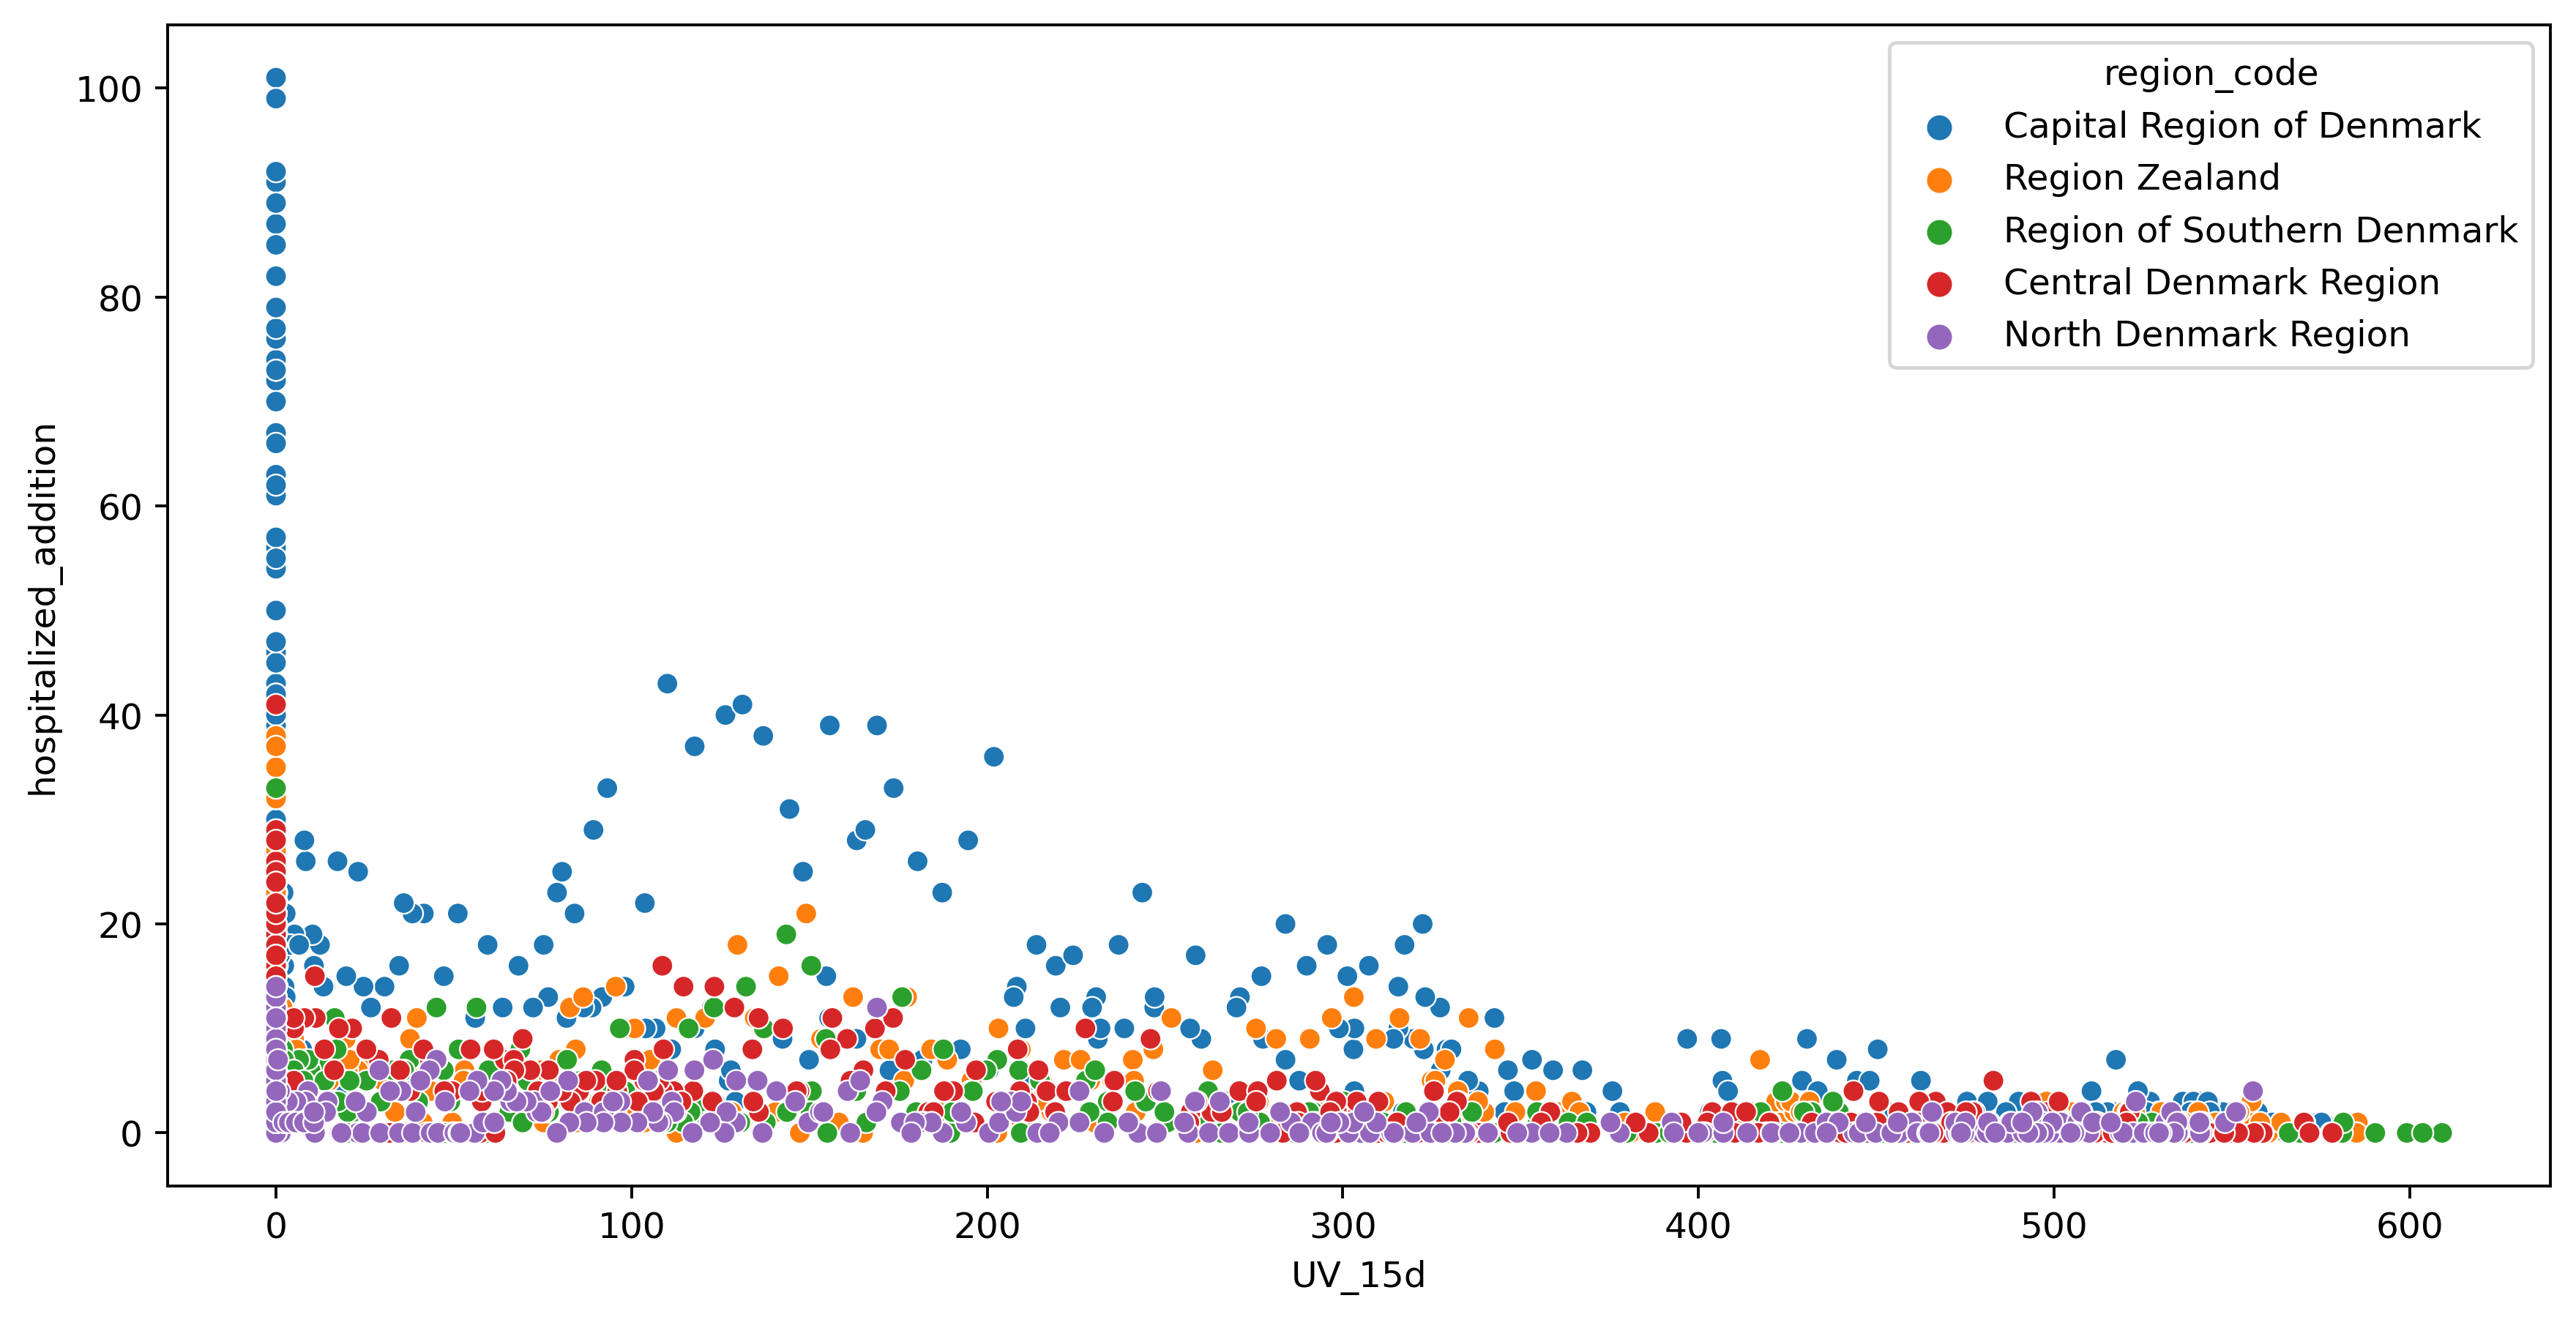

In [32]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=350)
sns.scatterplot(x='UV_15d', y='hospitalized_addition', data=covid_uv, hue='region_code');

We segregate the correlation acording to the region to get a clearer picture.

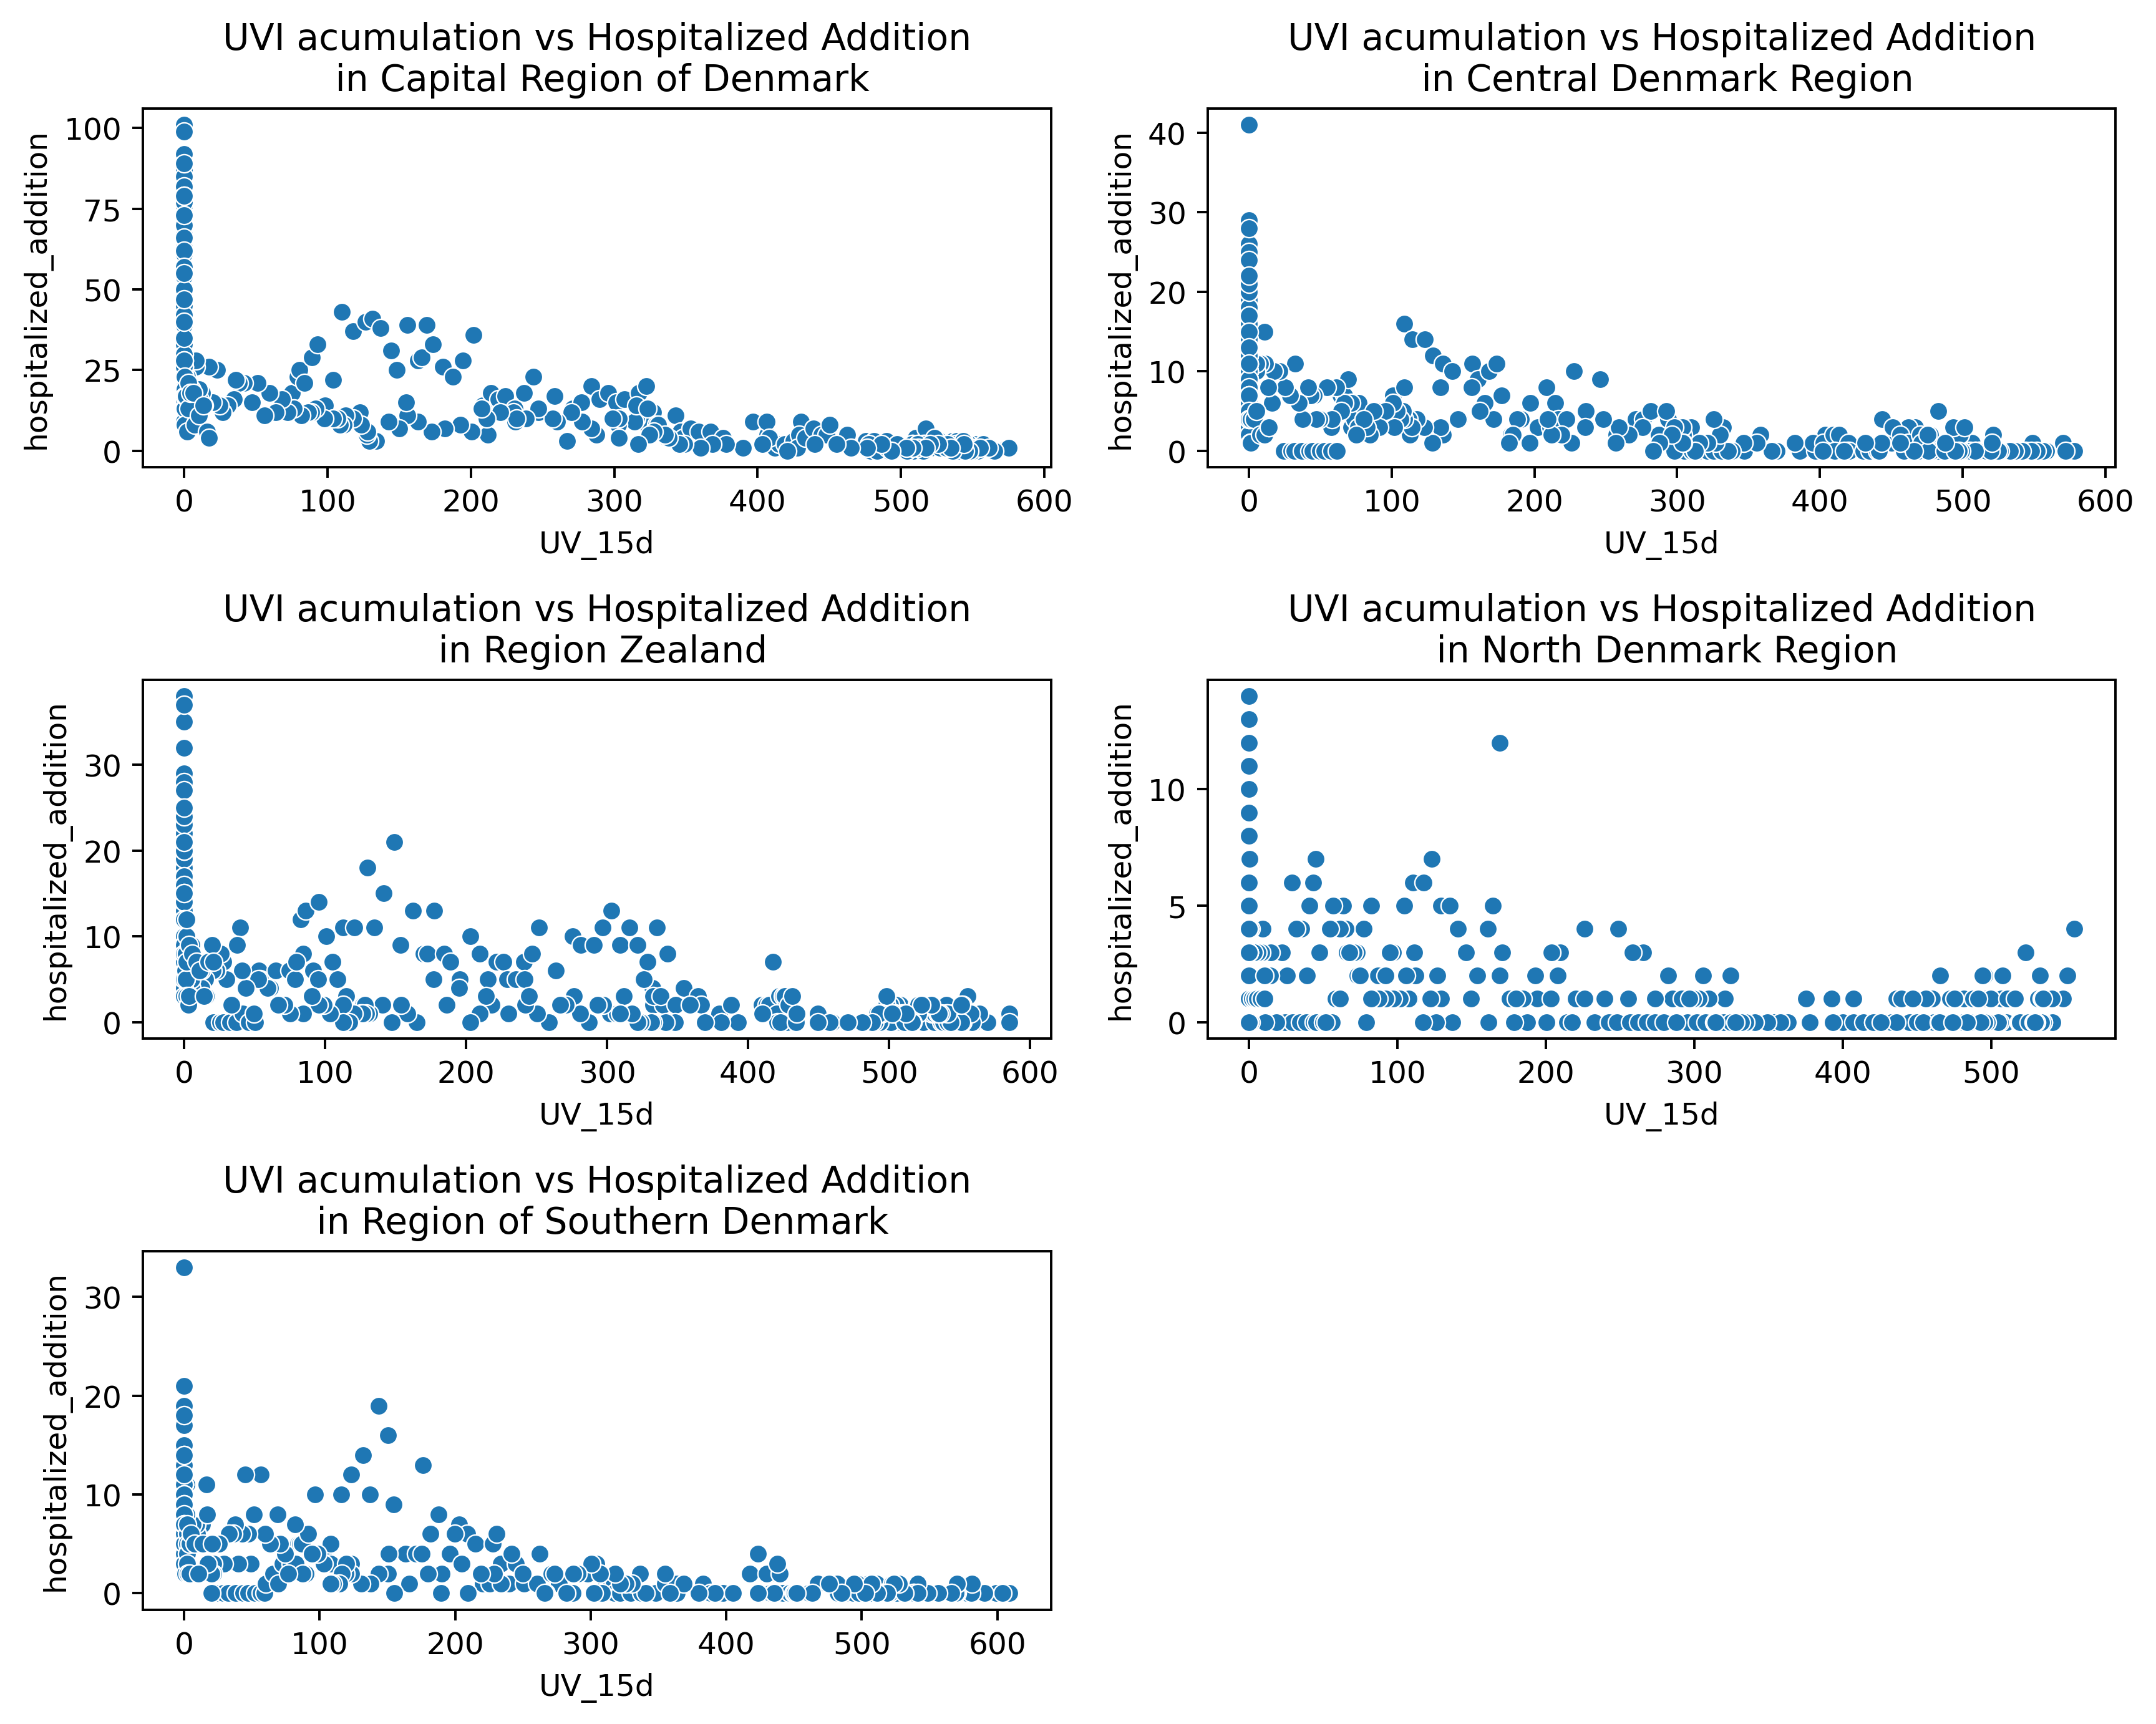

In [33]:
fig, ax = plt.subplots(3,2, figsize=(10,8), dpi=350)
id = 0
axid = (0,0)


for region in list(covid_uv['region_code'].unique()):
    temp = covid_uv[covid_uv['region_code'] == region]
    sns.scatterplot(x='UV_15d', y='hospitalized_addition', data=temp, ax=ax[axid])
    ax[axid].set_title(f'UVI acumulation vs Hospitalized Addition\n in {region}')
    plt.tight_layout()
    id += 1
    if id < 3:
        axid = (id, 0)
    else:
        axid = (id-3, 1)

fig.delaxes(ax[2,1])
    

### Is there a reason to believe the (supposed) effect of acumulated UV 'fades away' after 350 UVs?

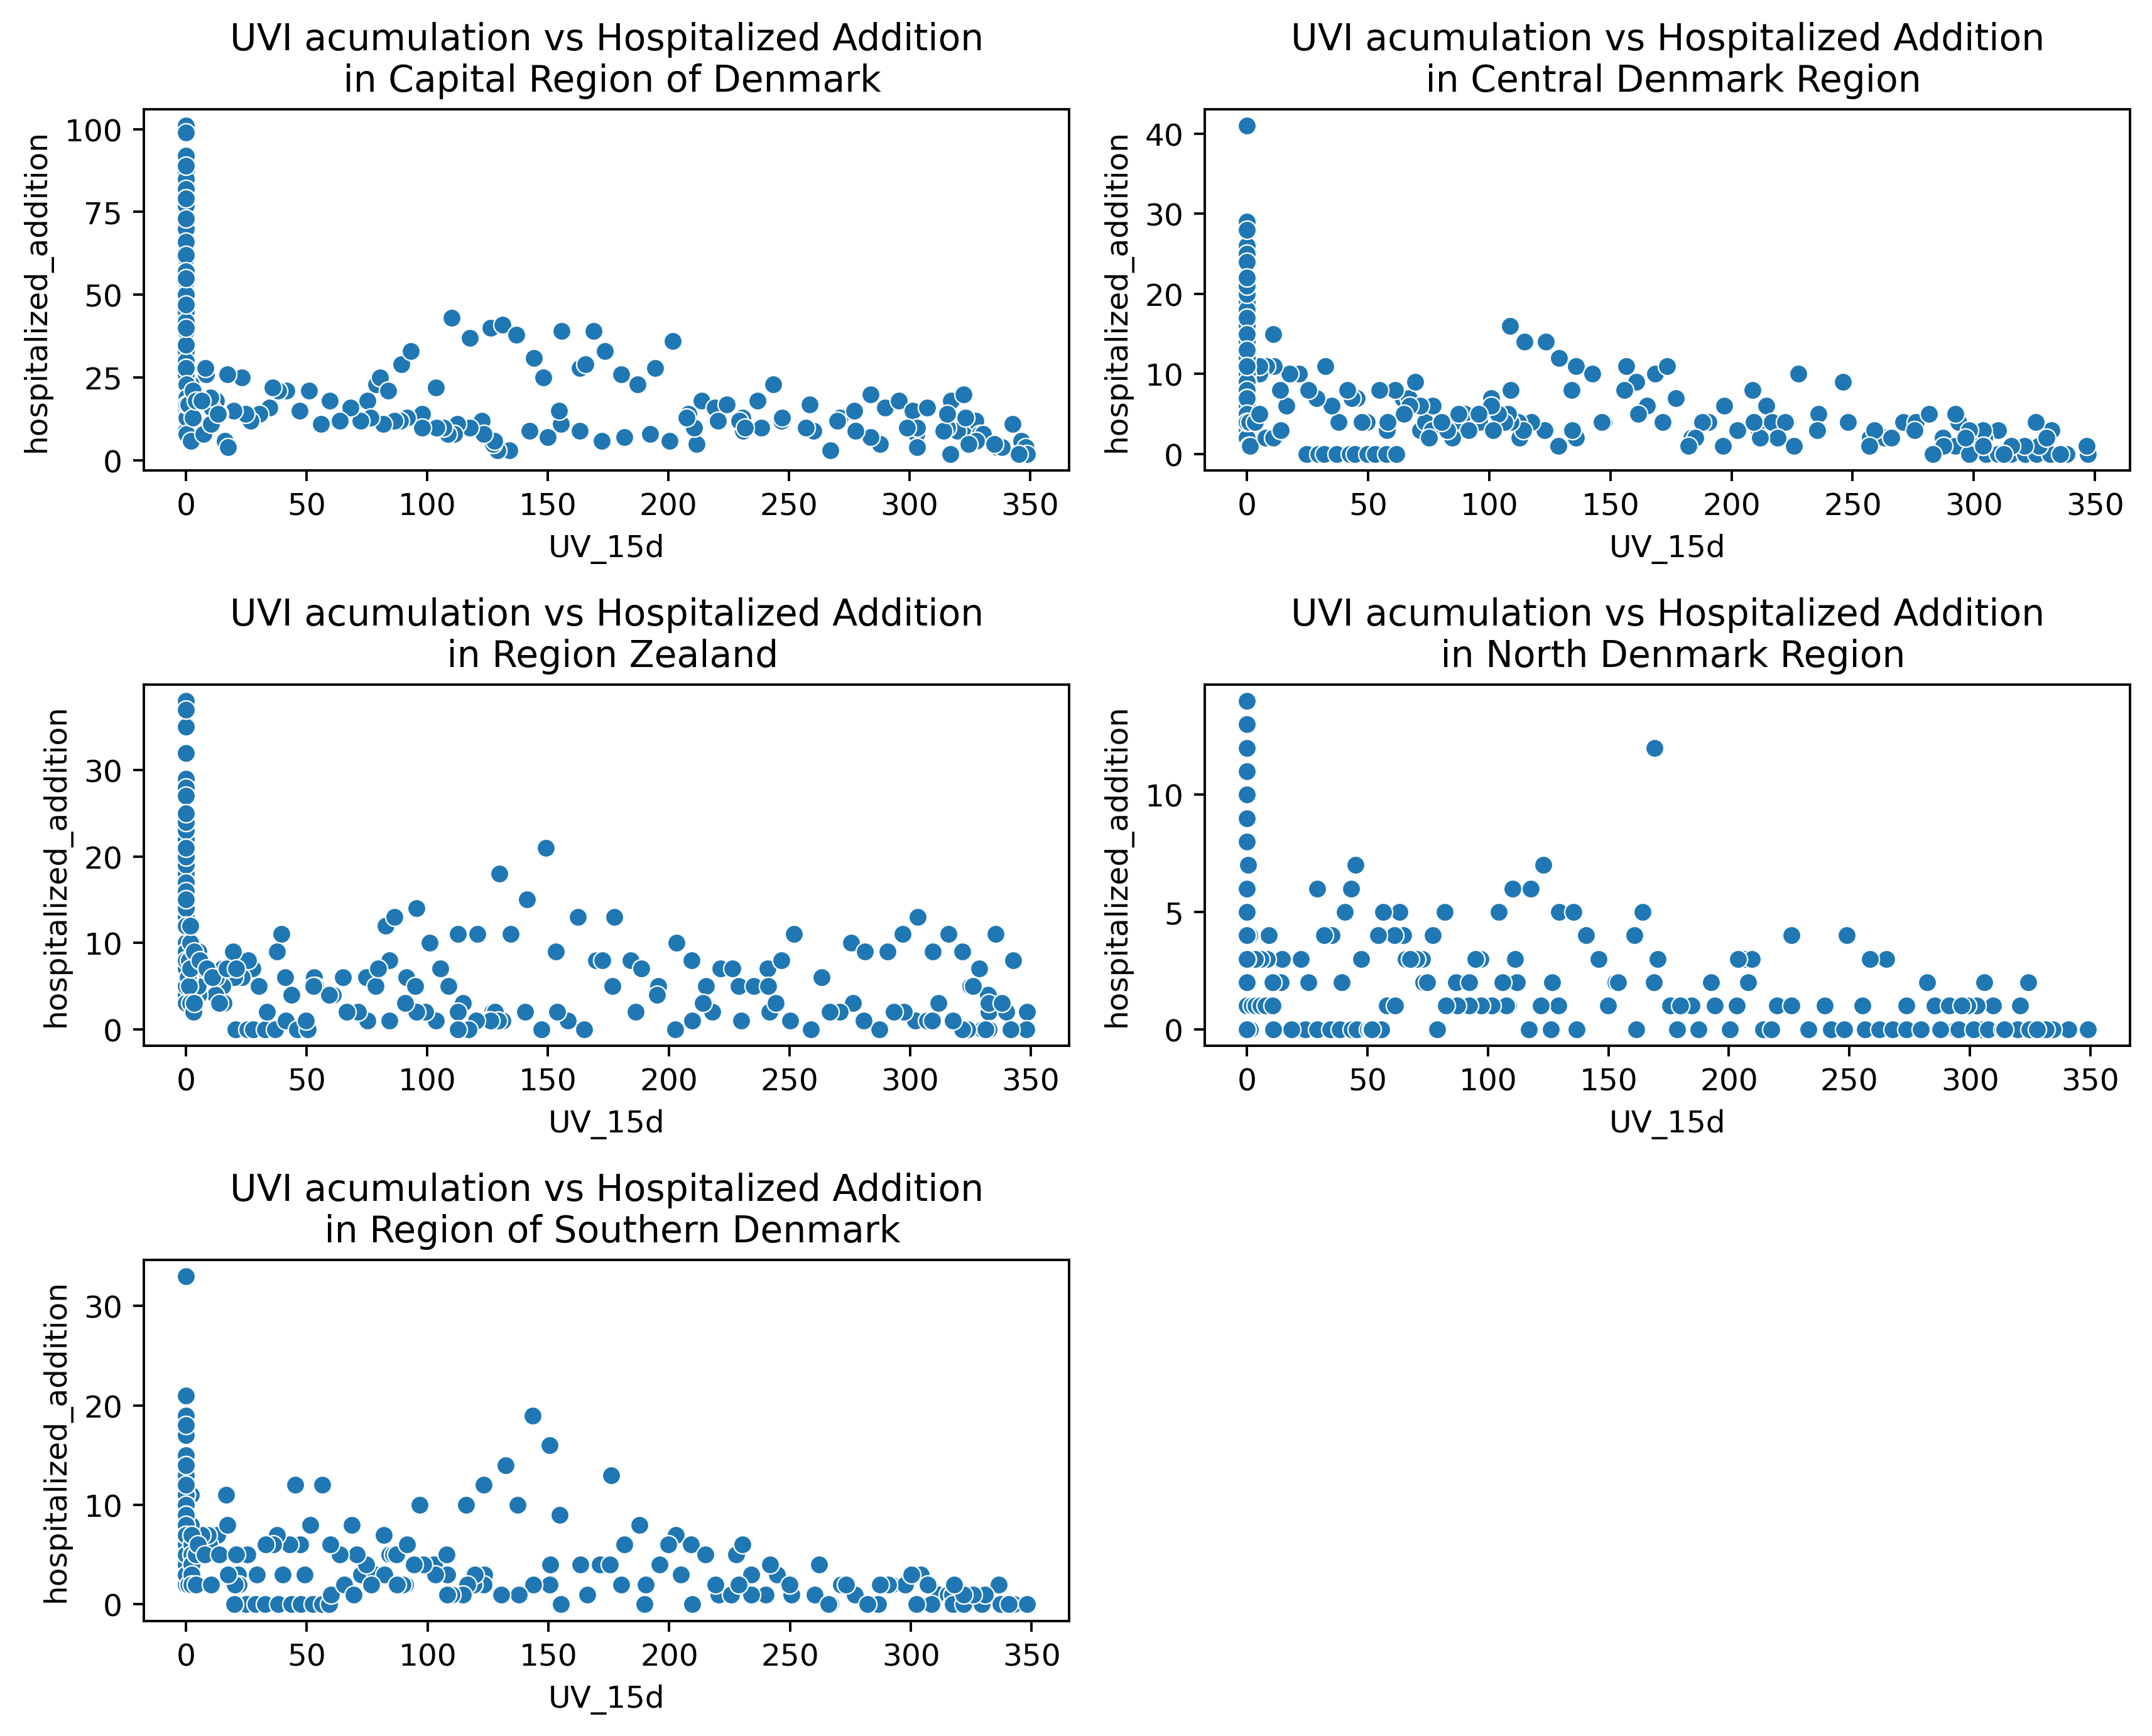

In [34]:
fig, ax = plt.subplots(3,2, figsize=(10,8), dpi=350)
id = 0
axid = (0,0)


for region in list(covid_uv['region_code'].unique()):
    temp = covid_uv[(covid_uv['region_code'] == region) & (covid_uv['UV_15d'] <= 350)]
    sns.scatterplot(x='UV_15d', y='hospitalized_addition', data=temp, ax=ax[axid])
    ax[axid].set_title(f'UVI acumulation vs Hospitalized Addition\n in {region}')
    plt.tight_layout()
    id += 1
    if id < 3:
        axid = (id, 0)
    else:
        axid = (id-3, 1)

fig.delaxes(ax[2,1])
    

## We aggregate corona cases by region, and add the population

In [35]:
covid_by_region = df['dk_corona'].groupby('region_code').sum()

pop = []
code = []

for i in list(covid_by_region.index):
    for j in df['dk_metadata']['country_metadata']:
        if i == j['iso3166-2_name_en']:
            pop.append(j['population'])
            code.append(j['iso3166-2_code'])

covid_by_region['pop'] = pop
covid_by_region['code'] = code

covid_by_region

,hospitalized_addition,pop,code
region_code,,,
Capital Region of Denmark,6041,1846023,DK-84
Central Denmark Region,1788,1326340,DK-82
North Denmark Region,767,589936,DK-81
Region Zealand,2104,837359,DK-85
Region of Southern Denmark,1312,1223105,DK-83


## We visualize the cases by region

In [36]:
m_cases = folium.Map(location = [56, 10.3], zoom_start = 7)

folium.Choropleth(
    geo_data = df['dk'],
    name = "cases",
    data = covid_by_region,
    columns = ['code', 'hospitalized_addition'],
    key_on = 'properties.iso_3166_2',
    fill_color =  'OrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Number of Cases"
).add_to(m_cases)
m_cases

## We visualize the cases per 100 thousand habitants by region

In [37]:
covid_by_region['cases_cap'] = covid_by_region['hospitalized_addition'] / covid_by_region['pop'] * 100000
covid_by_region

,hospitalized_addition,pop,code,cases_cap
region_code,,,,
Capital Region of Denmark,6041,1846023,DK-84,327.244027
Central Denmark Region,1788,1326340,DK-82,134.807063
North Denmark Region,767,589936,DK-81,130.014103
Region Zealand,2104,837359,DK-85,251.266183
Region of Southern Denmark,1312,1223105,DK-83,107.267978


<BarContainer object of 5 artists>

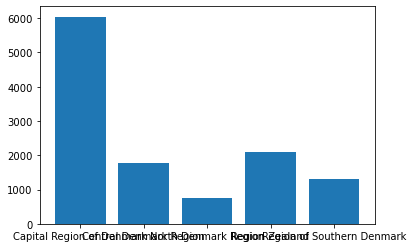

In [121]:
plt.bar(x_ax_cov_region, y_ax_covid)

In [119]:
y_ax_covid = covid_by_region['hospitalized_addition'].values
y_ax_covid

array([6041, 1788,  767, 2104, 1312])

In [115]:
covid_by_region_list = list(covid_by_region.index)
covid_by_region_list

['Capital Region of Denmark',
 'Central Denmark Region',
 'North Denmark Region',
 'Region Zealand',
 'Region of Southern Denmark']

In [120]:
x_ax_cov_region = covid_by_region_list
x_ax_cov_region

['Capital Region of Denmark',
 'Central Denmark Region',
 'North Denmark Region',
 'Region Zealand',
 'Region of Southern Denmark']

In [38]:
m_cases_pop_cap = folium.Map(location = [56, 10.3], zoom_start = 7)

folium.Choropleth(
    geo_data = df['dk'],
    name = "cases",
    data = covid_by_region,
    columns = ['code', 'cases_cap'],
    key_on = 'properties.iso_3166_2',
    fill_color =  'OrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Number of Cases"
).add_to(m_cases_pop_cap)
m_cases_pop_cap

This shows that the Capital Region of Denmark does not only contains the highest numbers for hospitalized patients because of it's population density, but also considering the per capita numbers.

In [58]:
df['dk_corona'].columns

Index(['date', 'region_code', 'hospitalized_addition'], dtype='object')

In [59]:
regions_index = df['dk_corona']['region_code'].unique()
regions_index

array(['Capital Region of Denmark', 'Region Zealand',
       'Region of Southern Denmark', 'Central Denmark Region',
       'North Denmark Region'], dtype=object)

In [60]:
list(regions_index)

['Capital Region of Denmark',
 'Region Zealand',
 'Region of Southern Denmark',
 'Central Denmark Region',
 'North Denmark Region']

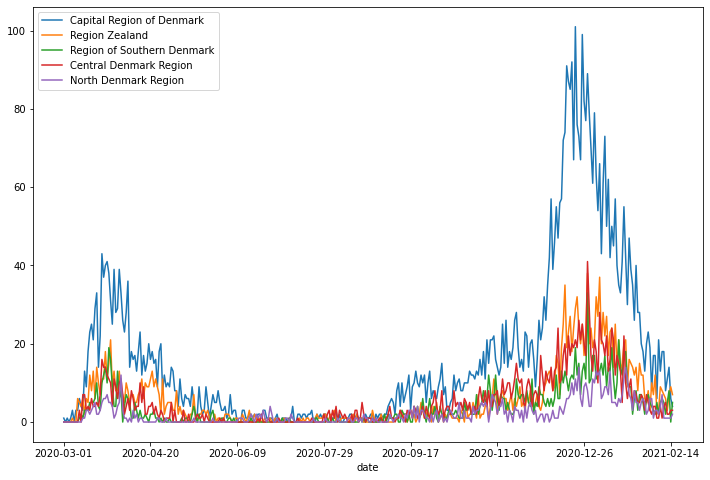

In [61]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

for region in regions_index: 
    region_df_index = df['dk_corona'].loc[df['dk_corona']['region_code'] == region]
    region_df_index.plot(x = 'date', y = 'hospitalized_addition', label = region, ax = ax)
plt.show()

In [83]:
df['dk_corona']

,date,region_code,hospitalized_addition
0,2020-03-01,Capital Region of Denmark,1
1,2020-03-02,Capital Region of Denmark,0
2,2020-03-03,Capital Region of Denmark,1
3,2020-03-04,Capital Region of Denmark,0
4,2020-03-05,Capital Region of Denmark,1
...,...,...,...
1755,2021-02-11,North Denmark Region,1
1756,2021-02-12,North Denmark Region,1
1757,2021-02-13,North Denmark Region,1
1758,2021-02-14,North Denmark Region,1


In [62]:
print(df['dk_corona'].corr(method="spearman"))

                       hospitalized_addition
hospitalized_addition                    1.0


# Weather - Cases Correlations

-- The weather variables are also correlated with each other. Do a multivariate regression to figure out which one is actually doing the work.

To do: 
UV ind - Region : Chloropeth

In [ ]:
How to combine the dataframe from covid cases and weather?

cases_cases = see above ... Isolate for Capital region:

In [87]:
weather_by_date 

,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
date,,,,,,,
2020-02-13,86.285064,2.422044e+06,2.404600e+06,276.786417,1.748400e-03,2.821490,4.423935
2020-02-14,87.398512,2.369072e+06,2.430333e+06,276.954369,7.356000e-04,1.513631,2.891248
2020-02-15,91.785362,1.906938e+05,2.416947e+06,279.620372,6.405000e-03,0.063312,7.025087
2020-02-16,88.155680,1.201935e+04,2.373562e+06,281.650593,1.473980e-02,0.016280,9.958726
2020-02-17,79.079660,3.399493e+06,2.390946e+06,279.783759,1.039200e-03,1.635729,10.505559
...,...,...,...,...,...,...,...
2021-02-11,75.114792,3.509902e+06,2.469831e+06,267.199177,5.026000e-04,1.816026,3.811492
2021-02-12,76.028840,4.770705e+06,2.488004e+06,266.684693,2.740000e-05,2.808084,2.553985
2021-02-13,80.648427,4.902966e+06,2.492454e+06,267.967806,4.000000e-07,2.969096,1.666899


In [95]:
temp = weather_by_date[weather_by_date.columns[0]]

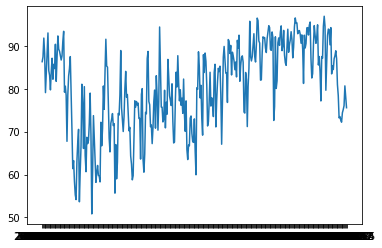

In [96]:
plt.plot(temp)

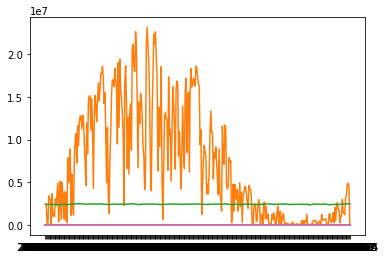

In [102]:
for i in range(len(weather_by_date.columns)):
    plt.plot(weather_by_date[weather_by_date.columns[i]])
plt.show()

# need to normalise plot variables y scale (cm? uv?)




In [ ]:
# Capital region Data Frame 


In [ ]:
# Weather Data Frame

In [ ]:
# Seaborn bar plot  # We plot the data



fig, ax = plt.subplots(figsize=(15,8), dpi=350)
ax = sns.barplot(x='Area', y='acc_per_100k', data=major_cities, linewidth=2.5)


ax.set_xticklabels(major_cities['Area'], rotation=45)
ax.set_ylabel("Accidents per year every 100 thousand hab.")
ax.set_ylim(0,275)
ax2 = ax.twinx()
ax2 = sns.barplot(x='Area', y='deaths_per_100k', data=major_cities, edgecolor= 'k', linewidth=2.5, alpha=0.45)
ax2.set_ylabel("Deaths per year every 100 thousand hab.")
ax2.set_ylim(0,5.5)
plt.legend(["Accidents: Colors", 'Deaths: Lines'])


#plt.savefig('./plots/acc-per-100-cities.png')




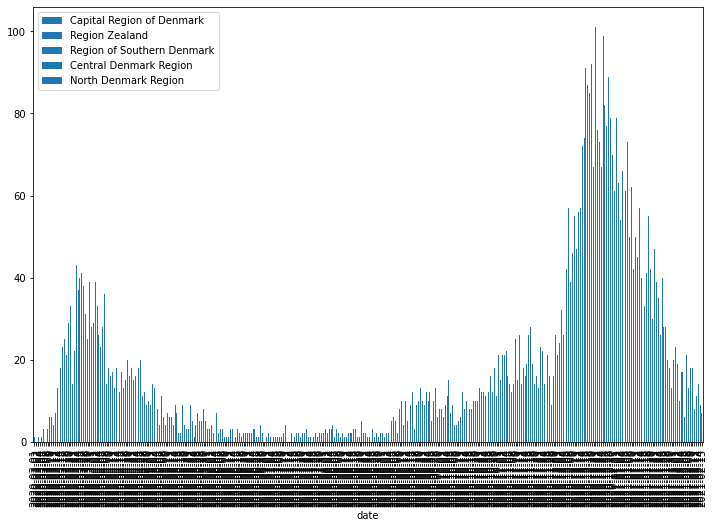

In [110]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

for region in regions_index: 
    region_df_index = df['dk_corona'].loc[df['dk_corona']['region_code'] == region]
    region_df_index.plot.bar(x = 'date', y = 'hospitalized_addition', label = region, ax = ax)

plt.show()


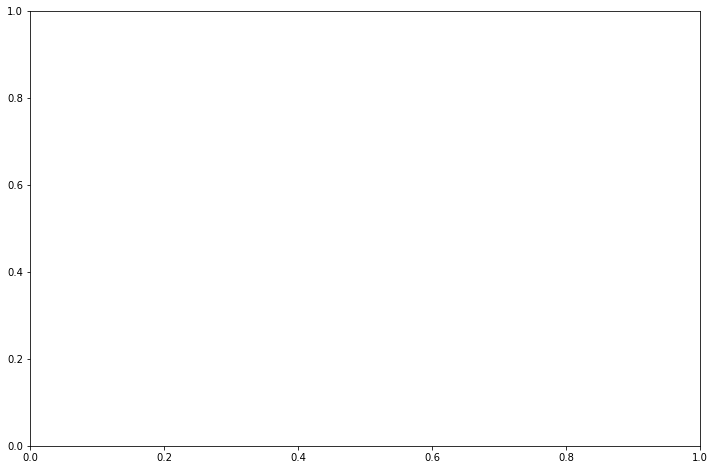

In [103]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

weather_by_date

plt.show()

KeyError: 'RelativeHumiditySurface'

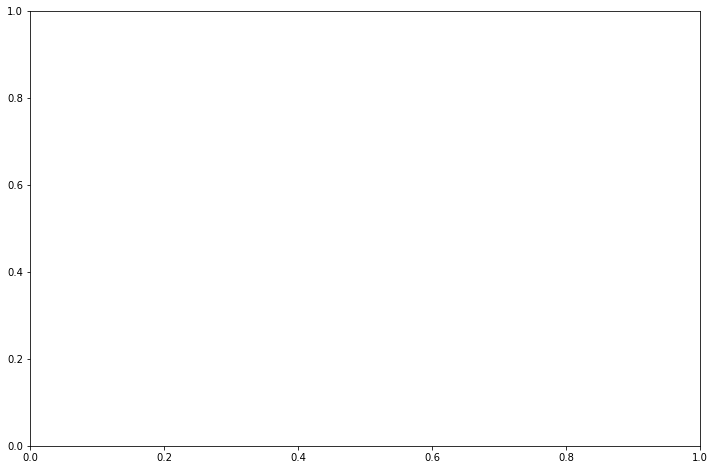

In [90]:


weather_index = weather_by_date['RelativeHumiditySurface']
region_df_index.plot(x = 'date', y = 'RelativeHumiditySurface', label = data, ax = ax)


In [ ]:
# We reload the unfiltered data of accidents for all cities:



In [ ]:
# We reload the unfiltered data of accidents for all cities:
unfiltered_acc = pd.DataFrame(pd.read_csv(PATH["data_interim"] + FILENAME['accidents'], dtype=None, low_memory=False))
unfiltered_cas = pd.DataFrame(pd.read_csv(PATH["data_interim"] + FILENAME['casualties'], dtype=None, low_memory=False))
unfiltered_acc.set_index("Accident_Index", inplace=True)
unfiltered_cas.set_index("Accident_Index", inplace=True)
unfiltered_merged = unfiltered_acc.merge(unfiltered_cas, left_index=True, right_index=True, how='inner')

# We get the estimated population for UK in 2019
all_cities = pd.read_excel('../data/external/nomis_2021_02_20_143234.xlsx', header=1, skiprows=5)
total_uk_pop = all_cities[2019].sum()

# We get all fatalities for the UK in 2019
deaths_uk = unfiltered_merged[unfiltered_merged['Casualty_Severity'] == 1].shape[0]

# We subset the 10 major cities
major_cities = all_cities[:10]

# We calculate the rate of accidents and fatalities every 100k for every major city
acc_per_100k = []
deaths_per_100k = []
for city in major_cities['Area']:
    code = references.get_code('Local_Authority_(District)', city)
    data_acc = unfiltered_acc[unfiltered_acc['Local_Authority_(District)'] == code]
    data_merged = unfiltered_merged[unfiltered_merged['Local_Authority_(District)'] == code]
    acc_per_100k.append(int(data_acc.shape[0] / (major_cities[2019][major_cities['Area'] == city]) *100000))
    deaths_per_100k.append(float((data_merged[data_merged["Casualty_Severity"] ==1].shape[0] / (major_cities[2019][major_cities['Area'] == city]) *100000)))

# We insert our new column to the existent dataframe
major_cities.insert(2, 'acc_per_100k', acc_per_100k)
major_cities.insert(3, 'deaths_per_100k', deaths_per_100k)

# We get the total number of accidents and deaths for the whole UK, and calculate accidents per 100k hab.
acc_total_uk = unfiltered_acc.shape[0]
uk_per_capita = int(acc_total_uk / total_uk_pop *100000)
uk_deaths_per_capita = float(deaths_uk / total_uk_pop * 100000)

# We append the new row to our major cities dataframe
total_uk_row = {"Area": "Total UK", 2019: total_uk_pop, 'acc_per_100k': uk_per_capita, 'deaths_per_100k': uk_deaths_per_capita}
major_cities = major_cities.append(total_uk_row, ignore_index=True)

# We sort the values in descending order
major_cities.sort_values("acc_per_100k", ascending=False, inplace=True)

# We plot the data
fig, ax = plt.subplots(figsize=(15,8), dpi=350)
ax = sns.barplot(x='Area', y='acc_per_100k', data=major_cities, linewidth=2.5)
ax.set_xticklabels(major_cities['Area'], rotation=45)
ax.set_ylabel("Accidents per year every 100 thousand hab.")
ax.set_ylim(0,275)
ax2 = ax.twinx()
ax2 = sns.barplot(x='Area', y='deaths_per_100k', data=major_cities, edgecolor= 'k', linewidth=2.5, alpha=0.45)
ax2.set_ylabel("Deaths per year every 100 thousand hab.")
ax2.set_ylim(0,5.5)
plt.legend(["Accidents: Colors", 'Deaths: Lines'])
#plt.savefig('./plots/acc-per-100-cities.png')


display(major_cities)


Windspeed and precipitation: 

Windspeed, precipitation, temperature:

To do: Plot: weather data + weather UV / check different ones... : Line plot with 2 axis see different project last one. 

Make spearman for UV weather and region cases :  See graph here that Gino did: 

In [ ]:
data.dropna(how='any')
corr(method='spearman')
sns.heatmap(corr, annot = True, ax = ax[axid]
plt.thigh_layout()
fig.delaxes(ax[2,1])

# An overview of the Multiple Comparison problem

t-test analysis function: https://towardsdatascience.com/an-overview-of-the-multiple-comparison-problem-166aa5fcaac5

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [66]:
rvs1 = stats.norm.rvs(loc=5, scale=10, size=1000, random_state=0)
rvs2 = stats.norm.rvs(loc=6.5, scale=8, size=1000, random_state=0)

In [67]:
def t_test_function(rvs, alpha, no_test):
    counter = 0
    for i in range(no_test):
        rvs_random = stats.norm.rvs(loc=5, scale=10, size=1000, random_state=i+1)

        statistic, pvalue = stats.ttest_ind(rvs, rvs_random, equal_var=False)

        if pvalue <= alpha:
            counter = counter + 1

    print(counter)

In [68]:
def bonferroni_correction_function(rvs, alpha, no_test):
    alpha_bonferroni = alpha/no_test
    
    counter = 0
    for i in range(no_test):
        rvs_random = stats.norm.rvs(loc=5, scale=10, size=1000, random_state=i+1)

        statistic, pvalue = stats.ttest_ind(rvs, rvs_random, equal_var=False)

        if pvalue <= alpha_bonferroni:
            counter = counter + 1

    print(counter)

In [69]:
def bonferroni_holm_correction_function(rvs, alpha, no_test):
    pvalue_test = []
    for i in range(no_test):
        rvs_random = stats.norm.rvs(loc=5, scale=10, size=1000, random_state=i+1)

        statistic, pvalue = stats.ttest_ind(rvs, rvs_random, equal_var=False)
        pvalue_test.append(pvalue)
        
    pvalue_test_sorted = sorted(pvalue_test, key=float)
    
    counter = 0
    for i in range(no_test):
        if pvalue_test_sorted[i] <= alpha/(no_test-i):
            counter = counter + 1

    print(counter)

In [ ]:
def sidak_correction_function(rvs, alpha, no_test):
    FWER = 1-(1-alpha)**(1/no_test)
    alpha_sidak = 1-(1-FWER)**(1/no_test)
    
    counter = 0
    for i in range(no_test):
        rvs_random = stats.norm.rvs(loc=5, scale=10, size=1000, random_state=i+1)

        statistic, pvalue = stats.ttest_ind(rvs, rvs_random, equal_var=False)

        if pvalue <= alpha_sidak:
            counter = counter + 1

    print(counter)
view raw

In [70]:
t_test_function(rvs1, alpha=0.05, no_test=100)
t_test_function(rvs2, alpha=0.05, no_test=100)

bonferroni_correction_function(rvs1, alpha=0.05, no_test=100)
bonferroni_correction_function(rvs2, alpha=0.05, no_test=100)

bonferroni_holm_correction_function(rvs1, alpha=0.05, no_test=100)
bonferroni_holm_correction_function(rvs2, alpha=0.05, no_test=100)

sidak_correction_function(rvs1, alpha=0.05, no_test=100)
sidak_correction_function(rvs2, alpha=0.05, no_test=100)

11
85
0
18
0
19


NameError: name 'sidak_correction_function' is not defined